# 필수 실행


## 구글드라이브 연결

In [230]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 필수 설치

In [231]:
!pip install category_encoders

## 필수 임포트

In [232]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.font_manager as fm

pd.set_option('display.max_columns', None)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')

## csv파일 불러오기


In [233]:
train_df = pd.read_csv('/content/drive/MyDrive/daegu/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/daegu/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/daegu/sample_submission.csv')
extra_train_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/countrywide_accident.csv')
light_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구보안등정보.csv',encoding='cp949')
child_area_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구어린이보호구역정보.csv',encoding='cp949')
parking_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구주차장정보.csv',encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구CCTV정보.csv',encoding='cp949')

In [234]:
train_df['사망자수'].value_counts()

0    39309
1      292
2        8
Name: 사망자수, dtype: int64

## 콜백리스트

In [235]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

## train/test data 합치기 및 컬럼정리


- 필요없다고 생각한 컬럼 정리

In [236]:
light_df = light_df.drop(columns=['보안등위치명','소재지도로명주소','위도','경도'])
child_area_df = child_area_df.drop(columns=['소재지도로명주소','위도','경도','데이터기준일자'])
parking_df = parking_df.drop(columns=['주차장관리번호','소재지도로명주소','위도','경도','데이터기준일자'])
cctv_df = cctv_df.drop(columns=['소재지도로명주소','위도','경도'])

In [237]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

- 보안등 정보

In [238]:
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

In [239]:
light_df = pd.get_dummies(light_df, columns=['설치형태'])

In [240]:
light_df['설치개수평균'] = light_df['설치개수']

light_ = light_df[['설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
                   '설치개수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
light__ = light_df[['설치개수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [241]:
light_.reset_index(inplace=True, drop=True)
light__.reset_index(inplace=True, drop=True)

- 어린이 보호구역

In [242]:
child_area_df['CCTV설치대수'].fillna(0, inplace=True)
child_area_df['CCTV설치한곳의수'] = 1
child_area_df['CCTV설치대수평균'] = child_area_df['CCTV설치대수']

In [243]:
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

In [244]:
child_area_df = pd.get_dummies(child_area_df, columns=['시설종류','관할경찰서명','CCTV설치여부'])

In [245]:
child_area_ = child_area_df[['시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y','CCTV설치한곳의수','CCTV설치대수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
child_area__ = child_area_df[['CCTV설치대수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [246]:
child_area_.reset_index(inplace=True, drop=True)
child_area__.reset_index(inplace=True, drop=True)

- 주차장 정보

In [247]:
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df['주차구획수평균'] = parking_df['주차구획수']

parking_df = pd.get_dummies(parking_df, columns=['급지구분','결제방법','주차장구분','주차장유형'])


parking_df_ = parking_df[['급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외','주차구획수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
parking_df__ = parking_df[['주차구획수평균','주차기본요금','추가단위요금',
                           '1일주차권요금','월정기권요금','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

parking_df_.reset_index(inplace=True, drop=True)
parking_df__.reset_index(inplace=True, drop=True)

- cctv 정보

In [248]:
cctv_df['무인CCTV설치한곳의수'] = 1

In [249]:
cctv_df[['도시', '구', '동', '번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소', '번지'])

In [250]:
cctv_df = pd.get_dummies(cctv_df, columns=['도로노선방향'])

In [251]:
cctv_ = cctv_df[['도로노선방향_1', '도로노선방향_2','도로노선방향_3',
                 '무인CCTV설치한곳의수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
cctv__ = cctv_df[['설치연도','제한속도','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [252]:
cctv_.reset_index(inplace=True, drop=True)
cctv__.reset_index(inplace=True, drop=True)

- '사고일시' 분리

In [253]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

- '시군구' 분리

In [254]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

- '도로형태'분리

In [255]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)

test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)

- 추가정보들 일단 모두 merge하기

In [256]:
print(f'{light_df.shape}/{child_area_df.shape}/{parking_df.shape}/{cctv_df.shape}')

(71913, 9)/(640, 24)/(871, 39)/(1065, 20)


In [257]:
parking_df.columns

Index(['주차장명', '주차구획수', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '특기사항', '도시',
       '구', '동', '주차구획수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드',
       '결제방법_무료', '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금',
       '결제방법_현금+신용카드', '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영',
       '주차장유형_노상', '주차장유형_노외'],
      dtype='object')

In [258]:
train_df = train_df.drop(columns=['사고유형 - 세부분류', '법규위반',
                                  '가해운전자 차종', '가해운전자 성별','가해운전자 연령', '가해운전자 상해정도',
                                  '피해운전자 차종','피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도',
                                  ])

In [259]:
train_df = pd.merge(train_df, light_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, light__, how='left', on=['도시', '구', '동'])

In [260]:
train_df = pd.merge(train_df, child_area_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area__, how='left', on=['도시', '구', '동'])

In [261]:
train_df = pd.merge(train_df, parking_df_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df__, how='left', on=['도시', '구', '동'])

In [262]:
train_df = pd.merge(train_df, cctv_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, cctv__, how='left', on=['도시', '구', '동'])

In [181]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사망자수', '중상자수', '경상자수',
       '부상자수', 'ECLO', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2',
       '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수', '설치개수평균', '시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균', '급지구분_1',
       '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [182]:
train_df.groupby(['시간','사고유형'])['ECLO'].mean()

시간  사고유형
0   차대사람    4.032051
    차대차     5.418239
    차량단독    3.444444
1   차대사람    3.543103
    차대차     5.690802
              ...   
22  차대차     5.310285
    차량단독    3.489362
23  차대사람    3.805128
    차대차     5.337209
    차량단독    3.170732
Name: ECLO, Length: 72, dtype: float64

In [183]:
train_df.groupby(['시간','도로형태2'])['ECLO'].mean()

시간  도로형태2    
0   고가도로위        7.500000
    교량           4.250000
    교차로부근        4.810811
    교차로안         5.990610
    교차로횡단보도내     4.375000
                   ...   
23  기타           4.648799
    미분류          6.000000
    주차장          3.333333
    지하차도(도로)내    7.222222
    터널           3.000000
Name: ECLO, Length: 213, dtype: float64

In [184]:
train_df.groupby(['시간','요일'])['ECLO'].mean()

시간  요일 
0   금요일    4.940171
    목요일    5.045455
    수요일    5.026786
    월요일    5.000000
    일요일    5.341270
             ...   
23  수요일    5.013072
    월요일    5.074627
    일요일    5.275591
    토요일    5.196429
    화요일    4.963415
Name: ECLO, Length: 168, dtype: float64

In [185]:
train_df.groupby(['시간','노면상태'])['ECLO'].mean()

시간  노면상태 
0   건조       5.066396
    기타       3.000000
    젖음/습기    5.134831
1   건조       5.304202
    서리/결빙    5.000000
               ...   
22  기타       3.400000
    젖음/습기    5.130208
23  건조       4.948507
    기타       3.000000
    젖음/습기    5.292683
Name: ECLO, Length: 87, dtype: float64

In [186]:
train_df.groupby(['시간','동'])['ECLO'].mean()

시간  동    
0   가천동      5.000000
    각산동      2.000000
    감삼동      5.181818
    검사동      3.000000
    계산동2가    6.000000
               ...   
23  호림동      4.500000
    호산동      5.000000
    화원읍      4.800000
    황금동      5.210526
    효목동      6.523810
Name: ECLO, Length: 3456, dtype: float64

In [187]:
_ant = train_df.groupby(['시간','사고유형'])['ECLO'].mean()

In [188]:
_ant

시간  사고유형
0   차대사람    4.032051
    차대차     5.418239
    차량단독    3.444444
1   차대사람    3.543103
    차대차     5.690802
              ...   
22  차대차     5.310285
    차량단독    3.489362
23  차대사람    3.805128
    차대차     5.337209
    차량단독    3.170732
Name: ECLO, Length: 72, dtype: float64

In [189]:
train_df = pd.merge(train_df, _ant, how='left', on=['시간','사고유형'])

In [190]:
train_df.head(1)

,ID,요일,기상상태,도로형태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO_x,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,설치개수,설치개수평균,시설종류_어린이집,시설종류_유치원,시설종류_초등학교,시설종류_특수학교,시설종류_학원,관할경찰서명_강북경찰서,관할경찰서명_남부경찰서,관할경찰서명_달성경찰서,관할경찰서명_대구광역시 중부경찰서,관할경찰서명_대구동부경찰서,관할경찰서명_북부경찰서,관할경찰서명_서부경찰서,관할경찰서명_수성경찰서,CCTV설치여부_N,CCTV설치여부_Y,CCTV설치한곳의수,CCTV설치대수,CCTV설치대수평균,급지구분_1,급지구분_2,급지구분_3,결제방법_교통카드,결제방법_무료,결제방법_신용카드,"결제방법_신용카드, 교통카드",결제방법_카드,결제방법_현금,결제방법_현금+신용카드,"결제방법_현금, 신용카드","결제방법_현금,카드",주차장구분_공영,주차장구분_민영,주차장유형_노상,주차장유형_노외,주차구획수,주차구획수평균,주차기본요금,추가단위요금,1일주차권요금,월정기권요금,도로노선방향_1,도로노선방향_2,도로노선방향_3,무인CCTV설치한곳의수,설치연도,제한속도,ECLO_y
0,ACCIDENT_00000,화요일,맑음,단일로 - 기타,건조,차대사람,0,1,0,0,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,177.0,30.0,135.0,391.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,13.0,6.5,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,11.0,0.0,11.0,500.0,45.45,1136.36,1100.0,NaN,NaN,0.0,1.0,4.0,5.0,2013.0,8.0,4.032051


In [390]:
train = train_df.copy()

In [391]:
train['사고유형'].unique()

array(['차대사람', '차대차', '차량단독'], dtype=object)

In [392]:
for i in ['사고유형','도로형태2','노면상태','요일']:

  _ant = train.groupby(['시간',i])['ECLO'].mean()
  train = pd.merge(train, _ant, how='left', on=['시간',i])
  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)


In [393]:
_ant = train.groupby(['동'])['ECLO'].mean()

train = pd.merge(train, _ant, how='left', on=['동'])

train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new동'}, inplace=True)

In [394]:
for k in ['new노면상태', 'new사고유형', 'new도로형태2', 'new요일','new동']:
  train['임시1'] = (train[k] < 3.5).astype(int)
  train['임시2'] = (train[k] >= 5).astype(int) + 1
  train[k] = train['임시2'] - train['임시1']

In [395]:
for i in ['new노면상태', 'new사고유형', 'new도로형태2','new동']: # 노면 4.4 / 사고유형 4.3 / 도로형태 4 / 동 4.1
  display(train.groupby([i])['ECLO'].mean())
  display(train[i].value_counts())

new노면상태
0    2.548387
1    4.670026
2    5.240434
Name: ECLO, dtype: float64

1    35527
2     4051
0       31
Name: new노면상태, dtype: int64

new사고유형
0    3.343629
1    4.598398
2    5.305941
Name: ECLO, dtype: float64

1    31708
2     7642
0      259
Name: new사고유형, dtype: int64

new도로형태2
0    3.077778
1    4.623140
2    5.373121
Name: ECLO, dtype: float64

1    33864
2     5655
0       90
Name: new도로형태2, dtype: int64

new동
0    3.275000
1    4.613868
2    5.369551
Name: ECLO, dtype: float64

1    33473
2     6056
0       80
Name: new동, dtype: int64

In [105]:
train_df.shape

(39609, 80)

In [356]:
train_ = train_df.copy()

In [357]:
train = train_[train_['ECLO'] >= 6]

In [360]:
for i in train.columns.tolist() :
  print(i)
  display(train[i].value_counts())
  display(train.groupby([i])['ECLO'].mean())
  print("-----------------------------------")

ID


ACCIDENT_00005    1
ACCIDENT_25683    1
ACCIDENT_25685    1
ACCIDENT_25687    1
ACCIDENT_25688    1
                 ..
ACCIDENT_12858    1
ACCIDENT_12861    1
ACCIDENT_12866    1
ACCIDENT_12873    1
ACCIDENT_39608    1
Name: ID, Length: 10645, dtype: int64

ID
ACCIDENT_00005     6.0
ACCIDENT_00006    18.0
ACCIDENT_00009     9.0
ACCIDENT_00014     8.0
ACCIDENT_00020    15.0
                  ... 
ACCIDENT_39598     6.0
ACCIDENT_39600     8.0
ACCIDENT_39601     6.0
ACCIDENT_39606    10.0
ACCIDENT_39608     6.0
Name: ECLO, Length: 10645, dtype: float64

-----------------------------------
요일


토요일    1672
금요일    1593
화요일    1551
월요일    1536
수요일    1524
목요일    1430
일요일    1339
Name: 요일, dtype: int64

요일
금요일    8.387320
목요일    8.388112
수요일    8.435696
월요일    8.548177
일요일    9.079910
토요일    8.812799
화요일    8.442940
Name: ECLO, dtype: float64

-----------------------------------
기상상태


맑음    9705
비      726
흐림     190
기타      16
안개       5
눈        3
Name: 기상상태, dtype: int64

기상상태
기타    8.750000
눈     8.000000
맑음    8.544565
비     9.017906
안개    7.000000
흐림    8.731579
Name: ECLO, dtype: float64

-----------------------------------
도로형태


단일로 - 기타           4964
교차로 - 교차로안         3147
교차로 - 교차로부근        1722
기타 - 기타             361
교차로 - 교차로횡단보도내      151
단일로 - 교량             87
단일로 - 지하차도(도로)내      78
단일로 - 고가도로위          64
주차장 - 주차장            37
단일로 - 터널             32
미분류 - 미분류             2
Name: 도로형태, dtype: int64

도로형태
교차로 - 교차로부근         8.588850
교차로 - 교차로안          8.563394
교차로 - 교차로횡단보도내      8.278146
기타 - 기타             7.603878
단일로 - 고가도로위         8.609375
단일로 - 교량            8.459770
단일로 - 기타            8.671636
단일로 - 지하차도(도로)내     8.461538
단일로 - 터널           10.156250
미분류 - 미분류           6.000000
주차장 - 주차장           7.189189
Name: ECLO, dtype: float64

-----------------------------------
노면상태


건조       9779
젖음/습기     849
서리/결빙       8
기타          7
침수          2
Name: 노면상태, dtype: int64

노면상태
건조       8.538808
기타       8.571429
서리/결빙    7.250000
젖음/습기    9.063604
침수       8.000000
Name: ECLO, dtype: float64

-----------------------------------
사고유형


차대차     10131
차대사람      379
차량단독      135
Name: 사고유형, dtype: int64

사고유형
차대사람    8.635884
차대차     8.559866
차량단독    9.903704
Name: ECLO, dtype: float64

-----------------------------------
사망자수


0    10345
1      292
2        8
Name: 사망자수, dtype: int64

사망자수
0     8.467472
1    12.023973
2    27.875000
Name: ECLO, dtype: float64

-----------------------------------
중상자수


0    7852
1    2044
2     618
3      98
4      28
5       4
6       1
Name: 중상자수, dtype: int64

중상자수
0     7.736755
1     9.711350
2    12.849515
3    18.448980
4    29.571429
5    29.500000
6    36.000000
Name: ECLO, dtype: float64

-----------------------------------
경상자수


2     5560
3     1728
1     1408
0      825
4      732
5      259
6       77
7       32
8        7
9        7
10       2
15       2
14       1
11       1
12       1
18       1
13       1
22       1
Name: 경상자수, dtype: int64

경상자수
0      9.810909
1      8.911222
2      6.673381
3      9.704861
4     12.930328
5     15.988417
6     19.727273
7     24.281250
8     25.428571
9     34.142857
10    35.000000
11    34.000000
12    56.000000
13    39.000000
14    47.000000
15    55.000000
18    74.000000
22    66.000000
Name: ECLO, dtype: float64

-----------------------------------
부상자수


0     9843
1      666
2       71
3       37
4       19
5        4
6        3
7        1
10       1
Name: 부상자수, dtype: int64

부상자수
0      8.529412
1      8.876877
2     11.028169
3      8.837838
4     10.947368
5     15.250000
6     19.333333
7      7.000000
10    19.000000
Name: ECLO, dtype: float64

-----------------------------------
ECLO


6     4967
9     1528
8     1152
12     611
10     611
11     394
15     283
7      263
13     194
14     145
16     101
18      89
17      78
20      39
19      36
21      33
24      18
22      17
23      17
26      12
27      11
25       7
28       6
30       5
31       4
32       3
37       3
34       3
33       2
35       2
36       1
47       1
65       1
56       1
40       1
57       1
45       1
52       1
74       1
39       1
66       1
Name: ECLO, dtype: int64

ECLO
6      6.0
7      7.0
8      8.0
9      9.0
10    10.0
11    11.0
12    12.0
13    13.0
14    14.0
15    15.0
16    16.0
17    17.0
18    18.0
19    19.0
20    20.0
21    21.0
22    22.0
23    23.0
24    24.0
25    25.0
26    26.0
27    27.0
28    28.0
30    30.0
31    31.0
32    32.0
33    33.0
34    34.0
35    35.0
36    36.0
37    37.0
39    39.0
40    40.0
45    45.0
47    47.0
52    52.0
56    56.0
57    57.0
65    65.0
66    66.0
74    74.0
Name: ECLO, dtype: float64

-----------------------------------
연


2019    3998
2020    3563
2021    3084
Name: 연, dtype: int64

연
2019    8.797149
2020    8.523435
2021    8.362516
Name: ECLO, dtype: float64

-----------------------------------
월


11    1017
10     960
7      940
5      909
8      907
6      906
9      886
4      879
3      853
12     823
1      799
2      766
Name: 월, dtype: int64

월
1     8.322904
2     8.711488
3     8.794842
4     8.657565
5     8.408141
6     8.752759
7     8.411702
8     8.542448
9     8.840858
10    8.519792
11    8.681416
12    8.294046
Name: ECLO, dtype: float64

-----------------------------------
일


12    384
5     371
3     367
11    367
26    362
27    361
6     361
10    361
13    358
23    358
18    355
7     351
4     349
25    349
14    348
2     347
9     347
20    346
29    346
8     345
21    344
22    343
28    343
17    342
1     332
30    327
15    325
16    319
19    318
24    317
31    202
Name: 일, dtype: int64

일
1     8.596386
2     8.671470
3     8.626703
4     8.931232
5     8.617251
6     8.445983
7     8.717949
8     8.278261
9     8.452450
10    8.761773
11    8.861035
12    8.518229
13    8.854749
14    8.658046
15    8.390769
16    8.667712
17    8.152047
18    8.616901
19    8.427673
20    8.468208
21    8.732558
22    8.982507
23    8.667598
24    8.492114
25    8.604585
26    8.381215
27    8.454294
28    8.399417
29    8.332370
30    8.577982
31    8.579208
Name: ECLO, dtype: float64

-----------------------------------
시간


18    867
19    741
17    723
16    667
15    635
14    594
20    586
13    571
12    525
11    509
8     501
21    498
10    446
22    433
9     418
23    375
7     302
0     275
1     224
2     187
6     181
5     147
3     124
4     116
Name: 시간, dtype: int64

시간
0     8.749091
1     9.218750
2     9.133690
3     9.379032
4     8.879310
5     9.299320
6     8.337017
7     8.483444
8     8.469062
9     8.746411
10    8.293722
11    8.381139
12    8.647619
13    8.600701
14    8.503367
15    8.749606
16    8.521739
17    8.533887
18    8.495963
19    8.383266
20    8.440273
21    8.489960
22    9.011547
23    8.240000
Name: ECLO, dtype: float64

-----------------------------------
도시


대구광역시    10645
Name: 도시, dtype: int64

도시
대구광역시    8.579615
Name: ECLO, dtype: float64

-----------------------------------
구


달서구    2619
수성구    1894
북구     1682
동구     1512
서구      913
달성군     824
남구      662
중구      539
Name: 구, dtype: int64

구
남구     8.489426
달서구    8.261932
달성군    8.951456
동구     8.830026
북구     8.722949
서구     8.930997
수성구    8.385956
중구     8.601113
Name: ECLO, dtype: float64

-----------------------------------
동


대명동    423
범어동    314
상인동    271
만촌동    265
내당동    263
      ... 
화전동      1
미대동      1
전동       1
완전동      1
도남동      1
Name: 동, Length: 187, dtype: int64

동
가창면    8.609756
가천동    9.800000
각산동    9.551020
갈산동    8.733333
감삼동    8.241026
         ...   
호산동    8.625000
화원읍    8.462963
화전동    6.000000
황금동    8.141892
효목동    8.766467
Name: ECLO, Length: 187, dtype: float64

-----------------------------------
도로형태1


단일로    5225
교차로    5020
기타      361
주차장      37
미분류       2
Name: 도로형태1, dtype: int64

도로형태1
교차로    8.563546
기타     7.603878
단일로    8.673301
미분류    6.000000
주차장    7.189189
Name: ECLO, dtype: float64

-----------------------------------
도로형태2


기타           5325
교차로안         3147
교차로부근        1722
교차로횡단보도내      151
교량             87
지하차도(도로)내      78
고가도로위          64
주차장            37
터널             32
미분류             2
Name: 도로형태2, dtype: int64

도로형태2
고가도로위         8.609375
교량            8.459770
교차로부근         8.588850
교차로안          8.563394
교차로횡단보도내      8.278146
기타            8.599249
미분류           6.000000
주차장           7.189189
지하차도(도로)내     8.461538
터널           10.156250
Name: ECLO, dtype: float64

-----------------------------------
설치형태_건축물


0.0       4923
1647.0     423
251.0      204
540.0      198
14.0       193
394.0      185
1.0        183
298.0      167
16.0       115
104.0      103
4.0         98
78.0        98
65.0        79
592.0       79
13.0        76
2.0         75
163.0       73
36.0        64
5.0         56
192.0       54
199.0       46
48.0        46
34.0        37
87.0        29
177.0       28
106.0       28
25.0        27
47.0        27
21.0        27
3.0         26
63.0        25
32.0        23
83.0        22
53.0        21
15.0        21
33.0        20
20.0        19
75.0        19
24.0        19
17.0        13
19.0        10
7.0          9
23.0         7
82.0         7
28.0         6
11.0         5
9.0          4
12.0         4
10.0         4
Name: 설치형태_건축물, dtype: int64

설치형태_건축물
0.0        8.525086
1.0        9.180328
2.0        8.933333
3.0        9.038462
4.0        8.908163
5.0        9.910714
7.0        9.888889
9.0        8.250000
10.0       7.750000
11.0       8.800000
12.0       7.500000
13.0       8.552632
14.0       8.450777
15.0       7.904762
16.0       8.547826
17.0       8.538462
19.0       7.100000
20.0       9.105263
21.0       7.592593
23.0       7.571429
24.0       7.631579
25.0      10.666667
28.0       7.000000
32.0       7.304348
33.0       9.700000
34.0       8.702703
36.0       9.437500
47.0       8.259259
48.0       9.326087
53.0       8.285714
63.0       8.400000
65.0       8.962025
75.0       9.315789
78.0       8.122449
82.0       7.857143
83.0       7.954545
87.0       9.793103
104.0      8.359223
106.0      8.321429
163.0      8.082192
177.0      7.928571
192.0      8.074074
199.0      8.434783
251.0      8.573529
298.0      8.766467
394.0      8.935135
540.0      8.323232
592.0      8.734177
1647.0     8.347518
Name: ECLO,

-----------------------------------
설치형태_전용주


0.0      5136
20.0      535
16.0      255
38.0      204
57.0      198
31.0      187
22.0      185
28.0      177
21.0      167
2.0       165
1.0       141
11.0       99
7.0        76
4.0        72
13.0       54
5.0        50
9.0        49
26.0       46
17.0       45
6.0        29
30.0       28
173.0      28
10.0       27
3.0        27
8.0        21
15.0       16
18.0        8
Name: 설치형태_전용주, dtype: int64

설치형태_전용주
0.0       8.514213
1.0       8.546099
2.0       8.612121
3.0      10.259259
4.0       9.638889
5.0       9.940000
6.0       8.172414
7.0       8.552632
8.0       8.285714
9.0       9.551020
10.0      8.259259
11.0      9.414141
13.0      8.074074
15.0      9.812500
16.0      8.396078
17.0      9.155556
18.0     15.625000
20.0      8.385047
21.0      8.766467
22.0      8.935135
26.0      8.434783
28.0      8.497175
30.0      7.928571
31.0      8.481283
38.0      8.573529
57.0      8.323232
173.0     8.321429
Name: ECLO, dtype: float64

-----------------------------------
설치형태_한전주


0.0       4925
3583.0     423
694.0      204
1396.0     198
425.0      187
          ... 
74.0         1
4.0          1
83.0         1
139.0        1
67.0         1
Name: 설치형태_한전주, Length: 78, dtype: int64

설치형태_한전주
0.0       8.507614
1.0       8.166667
2.0       6.333333
3.0       7.000000
4.0       6.000000
            ...   
787.0     8.122449
795.0     8.766467
974.0     8.935135
1396.0    8.323232
3583.0    8.347518
Name: ECLO, Length: 78, dtype: float64

-----------------------------------
설치개수


5377.0    423
843.0     271
968.0     209
876.0     208
1032.0    204
         ... 
24.0        2
29.0        2
81.0        1
22.0        1
148.0       1
Name: 설치개수, Length: 136, dtype: int64

설치개수
1.0        9.333333
2.0        6.500000
4.0       10.312500
5.0        7.000000
7.0        8.444444
            ...    
1365.0     8.061538
1424.0     8.935135
1474.0     8.734177
2057.0     8.323232
5377.0     8.347518
Name: ECLO, Length: 136, dtype: float64

-----------------------------------
설치개수평균


1.00    5970
1.02     844
1.03     389
1.05     290
1.01     276
1.04     239
1.17       9
1.07       8
Name: 설치개수평균, dtype: int64

설치개수평균
1.00     8.515243
1.01     8.822464
1.02     8.663507
1.03     8.575835
1.04     8.782427
1.05     8.727586
1.07    10.750000
1.17     8.444444
Name: ECLO, dtype: float64

-----------------------------------
시설종류_어린이집


3.0     1266
0.0     1141
4.0      803
2.0      636
1.0      607
7.0      423
8.0      420
12.0     162
6.0       80
5.0       79
Name: 시설종류_어린이집, dtype: int64

시설종류_어린이집
0.0      8.710780
1.0      8.828666
2.0      8.389937
3.0      8.488942
4.0      8.596513
5.0      8.734177
6.0     10.062500
7.0      8.347518
8.0      8.595238
12.0     8.462963
Name: ECLO, dtype: float64

-----------------------------------
시설종류_유치원


1.0     926
3.0     860
5.0     733
2.0     587
7.0     423
4.0     401
8.0     345
11.0    314
0.0     245
9.0     224
36.0    208
6.0     189
16.0    162
Name: 시설종류_유치원, dtype: int64

시설종류_유치원
0.0     8.742857
1.0     8.502160
2.0     8.741056
3.0     8.359302
4.0     8.583541
5.0     8.845839
6.0     9.010582
7.0     8.347518
8.0     8.820290
9.0     8.651786
11.0    8.328025
16.0    8.462963
36.0    8.793269
Name: ECLO, dtype: float64

-----------------------------------
시설종류_초등학교


3.0     1237
1.0      957
2.0      808
5.0      791
4.0      428
7.0      423
6.0      304
0.0      219
16.0     208
10.0     162
8.0       80
Name: 시설종류_초등학교, dtype: int64

시설종류_초등학교
0.0      8.456621
1.0      8.463950
2.0      8.779703
3.0      8.628133
4.0      8.640187
5.0      8.386852
6.0      8.894737
7.0      8.347518
8.0     10.062500
10.0     8.462963
16.0     8.793269
Name: ECLO, dtype: float64

-----------------------------------
시설종류_특수학교


0.0    4985
5.0     423
1.0     209
Name: 시설종류_특수학교, dtype: int64

시설종류_특수학교
0.0    8.631896
1.0    8.277512
5.0    8.347518
Name: ECLO, dtype: float64

-----------------------------------
시설종류_학원


0.0    5352
1.0     265
Name: 시설종류_학원, dtype: int64

시설종류_학원
0.0    8.604821
1.0    8.445283
Name: ECLO, dtype: float64

-----------------------------------
관할경찰서명_강북경찰서


0.0     4785
13.0     289
5.0      163
7.0      141
10.0      78
6.0       72
1.0       46
3.0       29
4.0       14
Name: 관할경찰서명_강북경찰서, dtype: int64

관할경찰서명_강북경찰서
0.0     8.570324
1.0     9.891304
3.0     9.793103
4.0     8.928571
5.0     8.901840
6.0     9.041667
7.0     8.241135
10.0    8.256410
13.0    8.685121
Name: ECLO, dtype: float64

-----------------------------------
관할경찰서명_남부경찰서


0.0     4955
26.0     423
8.0      185
6.0       54
Name: 관할경찰서명_남부경찰서, dtype: int64

관할경찰서명_남부경찰서
0.0     8.611705
6.0     8.074074
8.0     8.935135
26.0    8.347518
Name: ECLO, dtype: float64

-----------------------------------
관할경찰서명_달성경찰서


0.0     4964
60.0     208
38.0     162
22.0      80
12.0      80
8.0       68
6.0       55
Name: 관할경찰서명_달성경찰서, dtype: int64

관할경찰서명_달성경찰서
0.0      8.544923
6.0      9.490909
8.0      8.544118
12.0     9.575000
22.0    10.062500
38.0     8.462963
60.0     8.793269
Name: ECLO, dtype: float64

-----------------------------------
관할경찰서명_대구광역시 중부경찰서


0.0    5363
1.0     118
9.0      79
2.0      57
Name: 관할경찰서명_대구광역시 중부경찰서, dtype: int64

관할경찰서명_대구광역시 중부경찰서
0.0    8.603021
1.0    8.110169
2.0    8.877193
9.0    8.734177
Name: ECLO, dtype: float64

-----------------------------------
관할경찰서명_대구동부경찰서


0.0    5617
Name: 관할경찰서명_대구동부경찰서, dtype: int64

관할경찰서명_대구동부경찰서
0.0    8.597294
Name: ECLO, dtype: float64

-----------------------------------
관할경찰서명_북부경찰서


0.0     4994
8.0      209
7.0      173
11.0      84
5.0       68
4.0       50
1.0       21
2.0       18
Name: 관할경찰서명_북부경찰서, dtype: int64

관할경찰서명_북부경찰서
0.0     8.608931
1.0     8.476190
2.0     8.722222
4.0     7.960000
5.0     8.441176
7.0     8.606936
8.0     8.583732
11.0    8.428571
Name: ECLO, dtype: float64

-----------------------------------
관할경찰서명_서부경찰서


0.0     4788
9.0      263
19.0     224
18.0     212
2.0       82
5.0       48
Name: 관할경찰서명_서부경찰서, dtype: int64

관할경찰서명_서부경찰서
0.0     8.552632
2.0     9.036585
5.0     8.229167
9.0     9.452471
18.0    8.400943
19.0    8.651786
Name: ECLO, dtype: float64

-----------------------------------
관할경찰서명_수성경찰서


0.0     3853
5.0      538
19.0     314
18.0     265
4.0      198
7.0      174
10.0     125
1.0       76
8.0       31
2.0       25
3.0       18
Name: 관할경찰서명_수성경찰서, dtype: int64

관할경찰서명_수성경찰서
0.0     8.712172
1.0     8.394737
2.0     8.520000
3.0     8.333333
4.0     8.358586
5.0     8.405204
7.0     8.172414
8.0     8.000000
10.0    8.176000
18.0    8.445283
19.0    8.328025
Name: ECLO, dtype: float64

-----------------------------------
CCTV설치여부_N


0.0     4441
2.0      349
58.0     208
1.0      174
30.0     162
20.0      80
12.0      80
8.0       68
4.0       55
Name: CCTV설치여부_N, dtype: int64

CCTV설치여부_N
0.0      8.553704
1.0      8.528736
2.0      8.441261
4.0      9.490909
8.0      8.544118
12.0     9.575000
20.0    10.062500
30.0     8.462963
58.0     8.793269
Name: ECLO, dtype: float64

-----------------------------------
CCTV설치여부_Y


5.0     786
8.0     587
19.0    538
2.0     525
7.0     488
9.0     426
26.0    423
13.0    289
16.0    265
1.0     261
4.0     261
18.0    212
10.0    203
0.0     148
3.0     116
6.0      89
Name: CCTV설치여부_Y, dtype: int64

CCTV설치여부_Y
0.0     9.101351
1.0     8.536398
2.0     9.091429
3.0     8.758621
4.0     8.314176
5.0     8.519084
6.0     8.528090
7.0     8.346311
8.0     8.630324
9.0     9.117371
10.0    8.206897
13.0    8.685121
16.0    8.445283
18.0    8.400943
19.0    8.462825
26.0    8.347518
Name: ECLO, dtype: float64

-----------------------------------
CCTV설치한곳의수


5.0     817
19.0    538
8.0     493
7.0     488
18.0    477
26.0    423
9.0     342
13.0    289
4.0     262
1.0     261
60.0    208
10.0    203
2.0     182
6.0     181
38.0    162
11.0     84
12.0     80
22.0     80
3.0      47
Name: CCTV설치한곳의수, dtype: int64

CCTV설치한곳의수
1.0      8.536398
2.0      8.884615
3.0      9.234043
4.0      8.312977
5.0      8.496940
6.0      8.889503
7.0      8.346311
8.0      8.673428
9.0      9.286550
10.0     8.206897
11.0     8.428571
12.0     9.575000
13.0     8.685121
18.0     8.425577
19.0     8.462825
22.0    10.062500
26.0     8.347518
38.0     8.462963
60.0     8.793269
Name: ECLO, dtype: float64

-----------------------------------
CCTV설치대수


0.0      2741
106.0     423
34.0      394
4.0       353
18.0      191
50.0      180
23.0      173
14.0      151
22.0      114
49.0      109
17.0      103
9.0        91
32.0       84
61.0       79
36.0       78
6.0        52
20.0       50
16.0       37
2.0        33
7.0        29
13.0       28
12.0       27
11.0       25
19.0       25
1.0        21
10.0       14
5.0        11
8.0         1
Name: CCTV설치대수, dtype: int64

CCTV설치대수
0.0       8.541043
1.0       9.142857
2.0       8.242424
4.0       9.192635
5.0      11.363636
6.0       9.192308
7.0       9.793103
8.0       6.000000
9.0       8.153846
10.0      8.928571
11.0      8.400000
12.0      7.666667
13.0      7.928571
14.0      8.397351
16.0      8.864865
17.0      8.728155
18.0      8.664921
19.0      8.680000
20.0      7.960000
22.0      8.666667
23.0      8.606936
32.0      8.428571
34.0      8.748731
36.0      8.256410
49.0      8.596330
50.0      8.738889
61.0      8.734177
106.0     8.347518
Name: ECLO, dtype: float64

-----------------------------------
CCTV설치대수평균


0.00     2741
4.08      423
4.25      394
0.07      208
3.85      180
3.29      173
0.47      162
2.00      149
3.77      109
3.40      103
2.91       84
0.18       80
6.78       79
3.60       78
1.80       68
2.33       64
5.00       61
4.40       60
0.67       55
3.67       54
9.00       52
2.67       37
6.00       34
6.50       28
12.00      27
11.00      25
2.71       25
1.00       21
3.00       18
2.50       14
4.00       10
8.00        1
Name: CCTV설치대수평균, dtype: int64

CCTV설치대수평균
0.00      8.541043
0.07      8.793269
0.18     10.062500
0.47      8.462963
0.67      9.490909
1.00      9.142857
1.80      8.441176
2.00      8.167785
2.33      9.484375
2.50      8.928571
2.67      8.864865
2.71      8.680000
2.91      8.428571
3.00      8.722222
3.29      8.606936
3.40      8.728155
3.60      8.256410
3.67      8.074074
3.77      8.596330
3.85      8.738889
4.00      8.900000
4.08      8.347518
4.25      8.748731
4.40      9.200000
5.00      8.573770
6.00      9.441176
6.50      7.928571
6.78      8.734177
8.00      6.000000
9.00      8.692308
11.00     8.400000
12.00     7.666667
Name: ECLO, dtype: float64

-----------------------------------
급지구분_1


0.0     6299
20.0     473
1.0      448
6.0      295
8.0      268
7.0      204
9.0      203
11.0      93
3.0       84
12.0      79
4.0       76
5.0       66
2.0       52
16.0      23
Name: 급지구분_1, dtype: int64

급지구분_1
0.0     8.525480
1.0     8.392857
2.0     8.903846
3.0     8.297619
4.0     7.973684
5.0     8.696970
6.0     8.881356
7.0     8.573529
8.0     8.462687
9.0     8.916256
11.0    8.537634
12.0    8.734177
16.0    7.304348
20.0    8.306554
Name: ECLO, dtype: float64

-----------------------------------
급지구분_2


0.0     3714
1.0     1506
3.0     1045
2.0      524
18.0     263
15.0     249
14.0     240
30.0     224
12.0     212
29.0     209
7.0      195
9.0      152
13.0     109
8.0       21
Name: 급지구분_2, dtype: int64

급지구분_2
0.0     8.640011
1.0     8.260292
2.0     8.185115
3.0     8.355981
7.0     8.061538
8.0     8.238095
9.0     8.434211
12.0    8.400943
13.0    8.596330
14.0    8.854167
15.0    8.803213
18.0    9.452471
29.0    8.583732
30.0    8.651786
Name: ECLO, dtype: float64

-----------------------------------
급지구분_3


0.0     2723
2.0     1420
1.0     1358
3.0     1097
13.0     433
7.0      389
5.0      355
4.0      264
14.0     238
9.0      212
29.0      80
11.0      48
8.0       46
Name: 급지구분_3, dtype: int64

급지구분_3
0.0      8.526258
1.0      8.510309
2.0      8.590141
3.0      8.390155
4.0      9.151515
5.0      8.014085
7.0      8.125964
8.0      9.673913
9.0      8.400943
11.0     8.229167
13.0     8.618938
14.0     8.714286
29.0    10.062500
Name: ECLO, dtype: float64

-----------------------------------
결제방법_교통카드


0.0    8587
1.0      76
Name: 결제방법_교통카드, dtype: int64

결제방법_교통카드
0.0    8.516013
1.0    9.250000
Name: ECLO, dtype: float64

-----------------------------------
결제방법_무료


0.0    8312
1.0     337
2.0      14
Name: 결제방법_무료, dtype: int64

결제방법_무료
0.0    8.519851
1.0    8.578635
2.0    8.714286
Name: ECLO, dtype: float64

-----------------------------------
결제방법_신용카드


0.0    8478
1.0     185
Name: 결제방법_신용카드, dtype: int64

결제방법_신용카드
0.0    8.516159
1.0    8.810811
Name: ECLO, dtype: float64

-----------------------------------
결제방법_신용카드, 교통카드


0.0    8627
1.0      36
Name: 결제방법_신용카드, 교통카드, dtype: int64

결제방법_신용카드, 교통카드
0.0    8.524632
1.0    8.000000
Name: ECLO, dtype: float64

-----------------------------------
결제방법_카드


0.0    8238
1.0     327
2.0      98
Name: 결제방법_카드, dtype: int64

결제방법_카드
0.0    8.545764
1.0    8.171254
2.0    7.734694
Name: ECLO, dtype: float64

-----------------------------------
결제방법_현금


0.0     3370
1.0     1313
2.0     1013
3.0      780
4.0      552
13.0     423
6.0      279
7.0      254
5.0      232
8.0      212
11.0     136
10.0      76
16.0      23
Name: 결제방법_현금, dtype: int64

결제방법_현금
0.0     8.678635
1.0     8.321401
2.0     8.273445
3.0     8.561538
4.0     8.250000
5.0     8.478448
6.0     8.867384
7.0     8.452756
8.0     8.764151
10.0    9.250000
11.0    8.794118
13.0    8.347518
16.0    7.304348
Name: ECLO, dtype: float64

-----------------------------------
결제방법_현금+신용카드


0.0    8656
1.0       7
Name: 결제방법_현금+신용카드, dtype: int64

결제방법_현금+신용카드
0.0    8.523799
1.0    6.857143
Name: ECLO, dtype: float64

-----------------------------------
결제방법_현금, 신용카드


0.0    8471
1.0     192
Name: 결제방법_현금, 신용카드, dtype: int64

결제방법_현금, 신용카드
0.0    8.521072
1.0    8.583333
Name: ECLO, dtype: float64

-----------------------------------
결제방법_현금,카드


0.0    7953
1.0     710
Name: 결제방법_현금,카드, dtype: int64

결제방법_현금,카드
0.0    8.503206
1.0    8.738028
Name: ECLO, dtype: float64

-----------------------------------
주차장구분_공영


4.0     1329
2.0     1289
1.0     1080
3.0      856
21.0     635
14.0     441
5.0      350
6.0      340
15.0     308
7.0      303
18.0     263
49.0     224
0.0      215
40.0     209
12.0     185
22.0     173
13.0     159
29.0      80
19.0      76
10.0      54
11.0      48
8.0       46
Name: 주차장구분_공영, dtype: int64

주차장구분_공영
0.0      8.376744
1.0      8.557407
2.0      8.553142
3.0      8.425234
4.0      8.458239
5.0      8.077143
6.0      8.135294
7.0      8.468647
8.0      9.673913
10.0     8.240741
11.0     8.229167
12.0     8.935135
13.0     8.396226
14.0     8.278912
15.0     8.762987
18.0     9.452471
19.0     9.250000
21.0     8.365354
22.0     8.606936
29.0    10.062500
40.0     8.583732
49.0     8.651786
Name: ECLO, dtype: float64

-----------------------------------
주차장구분_민영


0.0     7183
2.0      495
1.0      231
3.0      218
5.0      174
7.0      129
10.0     105
4.0       47
11.0      28
8.0       27
14.0      23
6.0        3
Name: 주차장구분_민영, dtype: int64

주차장구분_민영
0.0     8.514270
1.0     8.510823
2.0     8.600000
3.0     8.610092
4.0     8.000000
5.0     8.643678
6.0     7.333333
7.0     8.434109
8.0     7.592593
10.0    9.400000
11.0    7.928571
14.0    7.304348
Name: ECLO, dtype: float64

-----------------------------------
주차장유형_노상


0.0     2909
1.0     1834
3.0      731
17.0     551
5.0      375
4.0      304
9.0      273
44.0     224
29.0     209
11.0     193
14.0     180
2.0      180
21.0     173
12.0     162
10.0      98
8.0       82
28.0      80
15.0      68
7.0       21
6.0       16
Name: 주차장유형_노상, dtype: int64

주차장유형_노상
0.0      8.416982
1.0      8.460742
2.0      8.422222
3.0      8.503420
4.0      8.881579
5.0      8.296000
6.0      9.125000
7.0      8.238095
8.0      8.939024
9.0      8.355311
10.0     8.091837
11.0     8.523316
12.0     8.462963
14.0     8.738889
15.0     8.441176
17.0     9.019964
21.0     8.606936
28.0    10.062500
29.0     8.583732
44.0     8.651786
Name: ECLO, dtype: float64

-----------------------------------
주차장유형_노외


1.0     1947
3.0     1578
2.0     1363
4.0      913
0.0      806
5.0      721
20.0     423
9.0      264
13.0     209
7.0      116
6.0       90
10.0      79
12.0      76
11.0      28
8.0       27
14.0      23
Name: 주차장유형_노외, dtype: int64

주차장유형_노외
0.0     8.657568
1.0     8.691834
2.0     8.641966
3.0     8.253485
4.0     8.491785
5.0     8.208044
6.0     9.577778
7.0     8.146552
8.0     7.592593
9.0     8.875000
10.0    8.632911
11.0    7.928571
12.0    9.250000
13.0    8.583732
14.0    7.304348
20.0    8.347518
Name: ECLO, dtype: float64

-----------------------------------
주차구획수


32.0     437
709.0    423
345.0    314
63.0     294
466.0    271
        ... 
150.0      3
20.0       1
51.0       1
22.0       1
11.0       1
Name: 주차구획수, Length: 107, dtype: int64

주차구획수
10.0       8.258065
11.0       6.000000
17.0       9.441176
20.0       8.000000
22.0       6.000000
            ...    
1035.0     9.452471
1423.0     9.250000
1475.0     8.583732
2574.0    10.062500
2725.0     8.651786
Name: ECLO, Length: 107, dtype: float64

-----------------------------------
주차구획수평균


33.76    423
86.25    314
93.20    271
10.67    265
57.50    263
        ... 
31.33      3
34.00      3
37.50      3
20.00      2
11.00      1
Name: 주차구획수평균, Length: 110, dtype: int64

주차구획수평균
10.00      8.258065
10.67      8.445283
11.00      6.000000
14.33      8.074074
15.75      8.739583
            ...    
224.00     8.333333
225.00     9.575000
229.33    10.312500
300.00    10.105263
643.00     9.375000
Name: ECLO, Length: 110, dtype: float64

-----------------------------------
주차기본요금


0.00       2665
1000.00     446
600.00      444
700.00      439
204.76      423
150.00      413
200.00      361
80.00       331
33.33       263
333.33      246
97.96       224
142.86      212
88.10       209
21.43       195
283.33      185
300.00      185
164.00      173
50.00       140
120.00      109
225.00      108
933.33      103
400.00       97
71.43        84
916.67       79
271.43       78
465.52       76
117.65       68
1250.00      53
500.00       50
545.45       36
166.67       34
1136.36      28
966.67       27
1137.50      23
275.00       21
900.00       19
750.00        6
1500.00       4
833.33        4
1333.33       2
Name: 주차기본요금, dtype: int64

주차기본요금
0.00        8.697561
21.43       8.061538
33.33       9.452471
50.00       7.821429
71.43       8.428571
80.00       8.123867
88.10       8.583732
97.96       8.651786
117.65      8.441176
120.00      8.596330
142.86      8.400943
150.00      8.384988
164.00      8.606936
166.67      8.911765
200.00      8.509695
204.76      8.347518
225.00      7.851852
271.43      8.256410
275.00      8.238095
283.33      8.935135
300.00      8.351351
333.33      7.979675
400.00      8.845361
465.52      9.250000
500.00      7.960000
545.45      8.000000
600.00      8.288288
700.00      8.284738
750.00      7.000000
833.33      6.750000
900.00     10.105263
916.67      8.734177
933.33      8.728155
966.67     10.666667
1000.00     8.573991
1136.36     7.928571
1137.50     7.304348
1250.00     7.641509
1333.33     8.000000
1500.00    14.000000
Name: ECLO, dtype: float64

-----------------------------------
추가단위요금


300.00     802
150.00     734
200.00     668
207.69     423
100.00     418
0.00       335
350.00     314
500.00     252
250.00     245
357.14     224
166.67     206
225.00     185
2000.00    183
462.50     173
1100.00    153
666.67     148
750.00     127
1500.00    120
1150.00    109
1000.00     99
594.44      76
916.67      50
333.33      46
625.00      31
900.00      29
1166.67     27
800.00      27
961.54      23
875.00      23
75.00       23
700.00      14
400.00       5
1250.00      1
Name: 추가단위요금, dtype: int64

추가단위요금
0.00        8.620896
75.00       8.565217
100.00      8.373206
150.00      8.185286
166.67      7.796117
200.00      8.353293
207.69      8.347518
225.00      8.935135
250.00      8.497959
300.00      8.789277
333.33      8.434783
350.00      8.328025
357.14      8.651786
400.00      6.400000
462.50      8.606936
500.00      8.543651
594.44      9.250000
625.00      7.838710
666.67      8.141892
700.00     10.071429
750.00      8.385827
800.00     10.666667
875.00      9.260870
900.00      9.793103
916.67      7.960000
961.54      7.304348
1000.00     8.424242
1100.00     8.130719
1150.00     8.596330
1166.67     7.592593
1250.00     6.000000
1500.00     8.341667
2000.00     8.360656
Name: ECLO, dtype: float64

-----------------------------------
1일주차권요금


6000.00     914
7000.00     565
2000.00     543
0.00        514
10000.00    505
3000.00     463
3545.45     423
5000.00     327
3500.00     271
6857.14     224
4666.67     209
4000.00     200
4250.00     185
1000.00     116
3666.67     108
3333.33      98
15083.33     76
8333.33      69
5250.00      50
8500.00      27
8000.00      26
1500.00      23
50000.00      4
15000.00      2
Name: 1일주차권요금, dtype: int64

1일주차권요금
0.00         8.445525
1000.00      8.146552
1500.00      8.565217
2000.00      8.327808
3000.00      8.360691
3333.33      7.734694
3500.00      7.885609
3545.45      8.347518
3666.67      7.851852
4000.00      8.785000
4250.00      8.935135
4666.67      8.583732
5000.00      8.122324
5250.00      7.960000
6000.00      8.766958
6857.14      8.651786
7000.00      8.403540
8000.00      7.923077
8333.33      8.057971
8500.00     10.666667
10000.00     8.619802
15000.00     8.000000
15083.33     9.250000
50000.00     9.500000
Name: ECLO, dtype: float64

-----------------------------------
월정기권요금


40000.00     760
20000.00     664
80000.00     527
0.00         514
60000.00     483
50000.00     441
85000.00     423
57272.73     423
100000.00    355
70000.00     263
94285.71     224
86000.00     212
63750.00     185
30000.00     112
55000.00      78
65000.00      68
83333.33      46
120000.00      2
Name: 월정기권요금, dtype: int64

월정기권요금
0.00         8.445525
20000.00     8.248494
30000.00     8.526786
40000.00     8.509211
50000.00     7.909297
55000.00     8.256410
57272.73     8.347518
60000.00     8.368530
63750.00     8.935135
65000.00     8.441176
70000.00     8.460076
80000.00     8.388994
83333.33     8.434783
85000.00     8.397163
86000.00     8.400943
94285.71     8.651786
100000.00    8.777465
120000.00    8.000000
Name: ECLO, dtype: float64

-----------------------------------
도로노선방향_1


2.0     1888
1.0     1259
7.0     1215
6.0      952
3.0      861
8.0      707
0.0      692
4.0      583
5.0      544
17.0     423
9.0      278
11.0     271
23.0     208
15.0     162
14.0      80
10.0      41
Name: 도로노선방향_1, dtype: int64

도로노선방향_1
0.0      8.901734
1.0      8.656076
2.0      8.605403
3.0      8.414634
4.0      8.416810
5.0      8.459559
6.0      8.342437
7.0      8.592593
8.0      8.654880
9.0      8.683453
10.0     8.609756
11.0     7.885609
14.0    10.062500
15.0     8.462963
17.0     8.347518
23.0     8.793269
Name: ECLO, dtype: float64

-----------------------------------
도로노선방향_2


1.0     1801
2.0     1393
5.0     1217
3.0     1215
0.0      860
4.0      795
7.0      708
10.0     635
6.0      631
9.0      344
21.0     208
8.0      195
18.0     162
Name: 도로노선방향_2, dtype: int64

도로노선방향_2
0.0     8.888372
1.0     8.536924
2.0     8.589375
3.0     8.502881
4.0     8.685535
5.0     8.370583
6.0     8.938193
7.0     8.179379
8.0     8.507692
9.0     8.694767
10.0    8.365354
18.0    8.462963
21.0    8.793269
Name: ECLO, dtype: float64

-----------------------------------
도로노선방향_3


0.0     6547
4.0      745
2.0      449
35.0     423
13.0     316
12.0     271
6.0      197
8.0      195
18.0     195
10.0     195
15.0     185
5.0      171
1.0      167
3.0      108
Name: 도로노선방향_3, dtype: int64

도로노선방향_3
0.0     8.691309
1.0     8.910180
2.0     8.358575
3.0     7.851852
4.0     8.409396
5.0     7.964912
6.0     8.076142
8.0     8.241026
10.0    8.061538
12.0    7.885609
13.0    8.329114
15.0    8.935135
18.0    8.507692
35.0    8.347518
Name: ECLO, dtype: float64

-----------------------------------
무인CCTV설치한곳의수


12.0    1531
4.0      821
1.0      679
3.0      655
11.0     626
9.0      598
8.0      589
2.0      544
62.0     423
7.0      401
33.0     357
13.0     324
15.0     306
30.0     271
6.0      266
17.0     257
14.0     224
10.0     219
44.0     208
24.0     185
16.0     173
22.0     172
23.0     144
5.0      111
18.0      80
Name: 무인CCTV설치한곳의수, dtype: int64

무인CCTV설치한곳의수
1.0      8.882180
2.0      9.011029
3.0      8.616794
4.0      8.578563
5.0      9.765766
6.0      8.586466
7.0      8.433915
8.0      8.821732
9.0      8.361204
10.0     8.378995
11.0     8.287540
12.0     8.331156
13.0     8.750000
14.0     8.651786
15.0     8.467320
16.0     8.606936
17.0     8.505837
18.0    10.062500
22.0     8.232558
23.0     8.444444
24.0     8.935135
30.0     7.885609
33.0     8.487395
44.0     8.793269
62.0     8.347518
Name: ECLO, dtype: float64

-----------------------------------
설치연도


2018.25    556
2018.00    546
2016.98    423
2020.00    408
2019.00    404
          ... 
2017.20     16
2008.00      9
2014.80      8
2016.00      5
2006.00      4
Name: 설치연도, Length: 78, dtype: int64

설치연도
2006.00    6.750000
2007.50    7.592593
2008.00    7.666667
2010.00    9.419355
2011.00    8.820896
             ...   
2020.38    8.074074
2020.50    7.954545
2020.67    8.731183
2020.80    9.793103
2021.00    9.492063
Name: ECLO, Length: 78, dtype: float64

-----------------------------------
제한속도


50.00    1391
40.00     543
47.50     523
26.67     442
20.48     423
         ... 
22.50      21
12.00      16
80.00      11
92.00       8
13.33       5
Name: 제한속도, Length: 68, dtype: int64

제한속도
0.00       8.623318
8.00       7.928571
12.00     10.312500
13.33      6.400000
14.58      8.935135
            ...    
71.00      8.321429
76.67      8.552632
80.00     11.363636
92.00     15.625000
100.00     9.280000
Name: ECLO, Length: 68, dtype: float64

-----------------------------------


# 각컬럼별 ECLO평균

In [402]:
train_df.fillna(0, inplace=True)

In [232]:
for i in train_df.columns.tolist() :
  print(i)
  display(train_df.groupby([i])['ECLO'].mean().min())
  display(train_df.groupby([i])['ECLO'].mean().max())
  print("-----------------------------------")

ID


1.0

74.0

-----------------------------------
요일


4.560687619378364

5.210257656781721

-----------------------------------
기상상태


4.625

5.5

-----------------------------------
도로형태


3.7161016949152543

6.578125

-----------------------------------
노면상태


3.0

5.666666666666667

-----------------------------------
사고유형


3.8176496414459242

4.944596507786692

-----------------------------------
사망자수


4.667786003205372

27.875

-----------------------------------
중상자수


4.089427926732148

36.0

-----------------------------------
경상자수


3.441878257543155

74.0

-----------------------------------
부상자수


2.8912506178942166

19.333333333333332

-----------------------------------
ECLO


1.0

74.0

-----------------------------------
연


4.597049369488173

4.842184920198129

-----------------------------------
월


4.5444512568976085

4.88040629095675

-----------------------------------
일


4.527588813303099

4.889570552147239

-----------------------------------
시간


4.580698835274543

5.424157303370786

-----------------------------------
도시


4.726703526976192

4.726703526976192

-----------------------------------
구


4.541609822646658

5.072280448138779

-----------------------------------
동


2.3333333333333335

10.333333333333334

-----------------------------------
도로형태1


3.7161016949152543

4.882280916564632

-----------------------------------
도로형태2


3.7161016949152543

6.578125

-----------------------------------
설치형태_건축물


3.511013215859031

5.382978723404255

-----------------------------------
설치형태_전용주


3.6324786324786325

6.515151515151516

-----------------------------------
설치형태_한전주


3.2857142857142856

9.333333333333334

-----------------------------------
설치개수


2.5

10.333333333333334

-----------------------------------
설치개수평균


4.690759134444838

6.473684210526316

-----------------------------------
시설종류_어린이집


4.492281303602058

5.60077519379845

-----------------------------------
시설종류_유치원


4.492281303602058

4.993827160493828

-----------------------------------
시설종류_초등학교


4.492281303602058

5.60077519379845

-----------------------------------
시설종류_특수학교


4.398692810457517

4.745953115694873

-----------------------------------
시설종류_학원


4.724890829694323

4.8039647577092515

-----------------------------------
관할경찰서명_강북경찰서


4.326647564469914

5.593023255813954

-----------------------------------
관할경찰서명_남부경찰서


4.492281303602058

4.968

-----------------------------------
관할경찰서명_달성경찰서


4.7058037265752395

5.60077519379845

-----------------------------------
관할경찰서명_대구광역시 중부경찰서


4.588709677419355

4.7294876110089845

-----------------------------------
관할경찰서명_대구동부경찰서


4.726703526976192

4.726703526976192

-----------------------------------
관할경찰서명_북부경찰서


4.180147058823529

4.746197435132717

-----------------------------------
관할경찰서명_서부경찰서


4.461904761904762

5.106060606060606

-----------------------------------
관할경찰서명_수성경찰서


4.423611111111111

4.932270916334661

-----------------------------------
CCTV설치여부_N


4.613943028485757

5.60077519379845

-----------------------------------
CCTV설치여부_Y


4.464922711058264

5.0476190476190474

-----------------------------------
CCTV설치한곳의수


4.208920187793427

5.60077519379845

-----------------------------------
CCTV설치대수


4.180147058823529

7.12

-----------------------------------
CCTV설치대수평균


4.153846153846154

5.60077519379845

-----------------------------------
급지구분_1


4.320388349514563

5.044117647058823

-----------------------------------
급지구분_2


4.3425655976676385

5.018123667377399

-----------------------------------
급지구분_3


4.27087316762269

5.60077519379845

-----------------------------------
결제방법_교통카드


4.725896718392266

4.832775919732441

-----------------------------------
결제방법_무료


4.722524681549402

5.428571428571429

-----------------------------------
결제방법_신용카드


4.726025285229726

4.764790764790765

-----------------------------------
결제방법_신용카드, 교통카드


4.41764705882353

4.728035700702351

-----------------------------------
결제방법_카드


4.438172043010753

4.7362538879224

-----------------------------------
결제방법_현금


4.320388349514563

4.883616543764027

-----------------------------------
결제방법_현금+신용카드


4.444444444444445

4.726831855724786

-----------------------------------
결제방법_현금, 신용카드


4.677506775067751

4.7276375704252525

-----------------------------------
결제방법_현금,카드


4.697833935018051

4.728874290833084

-----------------------------------
주차장구분_공영


4.3595352016404645

5.60077519379845

-----------------------------------
주차장구분_민영


3.3333333333333335

4.860576923076923

-----------------------------------
주차장유형_노상


4.3029045643153525

5.60077519379845

-----------------------------------
주차장유형_노외


3.511013215859031

5.0120481927710845

-----------------------------------
주차구획수


2.5

10.333333333333334

-----------------------------------
주차구획수평균


2.5

10.333333333333334

-----------------------------------
주차기본요금


2.5

5.382978723404255

-----------------------------------
추가단위요금


3.392857142857143

6.303030303030303

-----------------------------------
1일주차권요금


3.789473684210526

5.382978723404255

-----------------------------------
월정기권요금


3.789473684210526

4.968

-----------------------------------
도로노선방향_1


4.293963254593176

5.60077519379845

-----------------------------------
도로노선방향_2


4.492027334851937

4.922497308934338

-----------------------------------
도로노선방향_3


4.293963254593176

4.968

-----------------------------------
무인CCTV설치한곳의수


4.293963254593176

5.60077519379845

-----------------------------------
설치연도


3.511013215859031

6.205882352941177

-----------------------------------
제한속도


3.392857142857143

7.12

-----------------------------------


도로형태     
3.7161016949152543     
6.578125    

-----------------------------------
노면상태     
3.0        
5.666666666666667      

-----------------------------------
사고유형        
3.8176496414459242      
4.944596507786692        

-----------------------------------
동      
2.3333333333333335      
10.333333333333334        

-----------------------------------
도로형태1         
3.7161016949152543          
4.882280916564632         

-----------------------------------
도로형태2        
3.7161016949152543         
6.578125    

-----------------------------------
설치형태_건축물         
3.511013215859031       
5.382978723404255        

-----------------------------------
설치형태_전용주               
3.6324786324786325              
6.515151515151516         

-----------------------------------
설치형태_한전주              
3.2857142857142856            
9.333333333333334       

-----------------------------------
설치개수            
2.5               
10.333333333333334           

-----------------------------------
주차장구분_민영       
3.3333333333333335         
4.860576923076923          

-----------------------------------
주차장유형_노외          
3.511013215859031           
5.0120481927710845        

-----------------------------------
주차구획수        
2.5             
10.333333333333334           

-----------------------------------
주차구획수평균            
2.5              
10.333333333333334           

-----------------------------------
주차기본요금             
2.5               
5.382978723404255            

-----------------------------------
추가단위요금                
3.392857142857143              
6.303030303030303             

-----------------------------------
1일주차권요금              
3.789473684210526               
5.382978723404255             

-----------------------------------
월정기권요금            
3.789473684210526              
4.968              

-----------------------------------
설치연도            
3.511013215859031          
6.205882352941177          

-----------------------------------
제한속도              
3.392857142857143             
7.12              


In [361]:
train_ = train_df[['도로형태','노면상태','사고유형','동','도로형태1','도로형태2','설치형태_건축물','설치형태_전용주','설치형태_한전주',
          '설치개수','주차장구분_민영','주차장유형_노외','주차구획수','주차구획수평균','주차기본요금','추가단위요금','1일주차권요금',
          '월정기권요금','설치연도','제한속도','ECLO']]

In [403]:
train_ = train_df[['동','설치형태_한전주', '설치개수','주차구획수','주차구획수평균','제한속도','ECLO']]

In [404]:
for i in  ['동','설치형태_한전주', '설치개수','주차구획수','주차구획수평균','제한속도']:
  _ant =  (train_.groupby([i])['ECLO'].mean() < 4).astype(int)
  train_df = pd.merge(train_df, _ant, how='left', on=[i])
  train_df.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

In [405]:
train_df.head(1)

,ID,요일,기상상태,도로형태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,설치개수,설치개수평균,시설종류_어린이집,시설종류_유치원,시설종류_초등학교,시설종류_특수학교,시설종류_학원,관할경찰서명_강북경찰서,관할경찰서명_남부경찰서,관할경찰서명_달성경찰서,관할경찰서명_대구광역시 중부경찰서,관할경찰서명_대구동부경찰서,관할경찰서명_북부경찰서,관할경찰서명_서부경찰서,관할경찰서명_수성경찰서,CCTV설치여부_N,CCTV설치여부_Y,CCTV설치한곳의수,CCTV설치대수,CCTV설치대수평균,급지구분_1,급지구분_2,급지구분_3,결제방법_교통카드,결제방법_무료,결제방법_신용카드,"결제방법_신용카드, 교통카드",결제방법_카드,결제방법_현금,결제방법_현금+신용카드,"결제방법_현금, 신용카드","결제방법_현금,카드",주차장구분_공영,주차장구분_민영,주차장유형_노상,주차장유형_노외,주차구획수,주차구획수평균,주차기본요금,추가단위요금,1일주차권요금,월정기권요금,도로노선방향_1,도로노선방향_2,도로노선방향_3,무인CCTV설치한곳의수,설치연도,제한속도,new동,new설치형태_한전주,new설치개수,new주차구획수,new주차구획수평균,new제한속도
0,ACCIDENT_00000,화요일,맑음,단일로 - 기타,건조,차대사람,0,1,0,0,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,177.0,30.0,135.0,391.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,13.0,6.5,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,11.0,0.0,11.0,500.0,45.45,1136.36,1100.0,0.0,0.0,0.0,1.0,4.0,5.0,2013.0,8.0,0,0,0,0,0,0


In [406]:
tr = train_df[['new동'	,'new설치형태_한전주'	,'new설치개수',	'new주차구획수',	'new주차구획수평균'	,'new제한속도','ECLO']]

In [407]:
for i in tr.columns.tolist() :
  display(tr.groupby([i])['ECLO'].mean())

new동
0    4.741101
1    3.611881
Name: ECLO, dtype: float64

new설치형태_한전주
0    4.739335
1    3.602273
Name: ECLO, dtype: float64

new설치개수
0    4.736541
1    3.752525
Name: ECLO, dtype: float64

new주차구획수
0    4.738110
1    3.591371
Name: ECLO, dtype: float64

new주차구획수평균
0    4.730875
1    3.691824
Name: ECLO, dtype: float64

new제한속도
0    4.727647
1    3.392857
Name: ECLO, dtype: float64

ECLO
1      1.0
2      2.0
3      3.0
4      4.0
5      5.0
6      6.0
7      7.0
8      8.0
9      9.0
10    10.0
11    11.0
12    12.0
13    13.0
14    14.0
15    15.0
16    16.0
17    17.0
18    18.0
19    19.0
20    20.0
21    21.0
22    22.0
23    23.0
24    24.0
25    25.0
26    26.0
27    27.0
28    28.0
30    30.0
31    31.0
32    32.0
33    33.0
34    34.0
35    35.0
36    36.0
37    37.0
39    39.0
40    40.0
45    45.0
47    47.0
52    52.0
56    56.0
57    57.0
65    65.0
66    66.0
74    74.0
Name: ECLO, dtype: float64

In [408]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(tr[['new동'	,'new설치형태_한전주'	,'new설치개수',	'new주차구획수']])
tr = tr.drop(['new동'	,'new설치형태_한전주'	,'new설치개수',	'new주차구획수'], axis=1)
tr['new'] = pca_temp

tr.shape

(39609, 4)

In [410]:
for i in tr.columns.tolist() :
  display(tr.groupby([i])['ECLO'].mean())

new주차구획수평균
0    4.730875
1    3.691824
Name: ECLO, dtype: float64

new제한속도
0    4.727647
1    3.392857
Name: ECLO, dtype: float64

ECLO
1      1.0
2      2.0
3      3.0
4      4.0
5      5.0
6      6.0
7      7.0
8      8.0
9      9.0
10    10.0
11    11.0
12    12.0
13    13.0
14    14.0
15    15.0
16    16.0
17    17.0
18    18.0
19    19.0
20    20.0
21    21.0
22    22.0
23    23.0
24    24.0
25    25.0
26    26.0
27    27.0
28    28.0
30    30.0
31    31.0
32    32.0
33    33.0
34    34.0
35    35.0
36    36.0
37    37.0
39    39.0
40    40.0
45    45.0
47    47.0
52    52.0
56    56.0
57    57.0
65    65.0
66    66.0
74    74.0
Name: ECLO, dtype: float64

new
-0.022003    4.740595
-0.022003    5.000000
 0.441274    5.961538
 0.457759    5.500000
 0.476313    4.250000
 0.531971    3.951220
 0.995247    3.666667
 1.030286    3.393939
 1.475008    3.775510
 1.493562    3.750000
 1.510047    3.590164
 1.973323    3.546099
Name: ECLO, dtype: float64

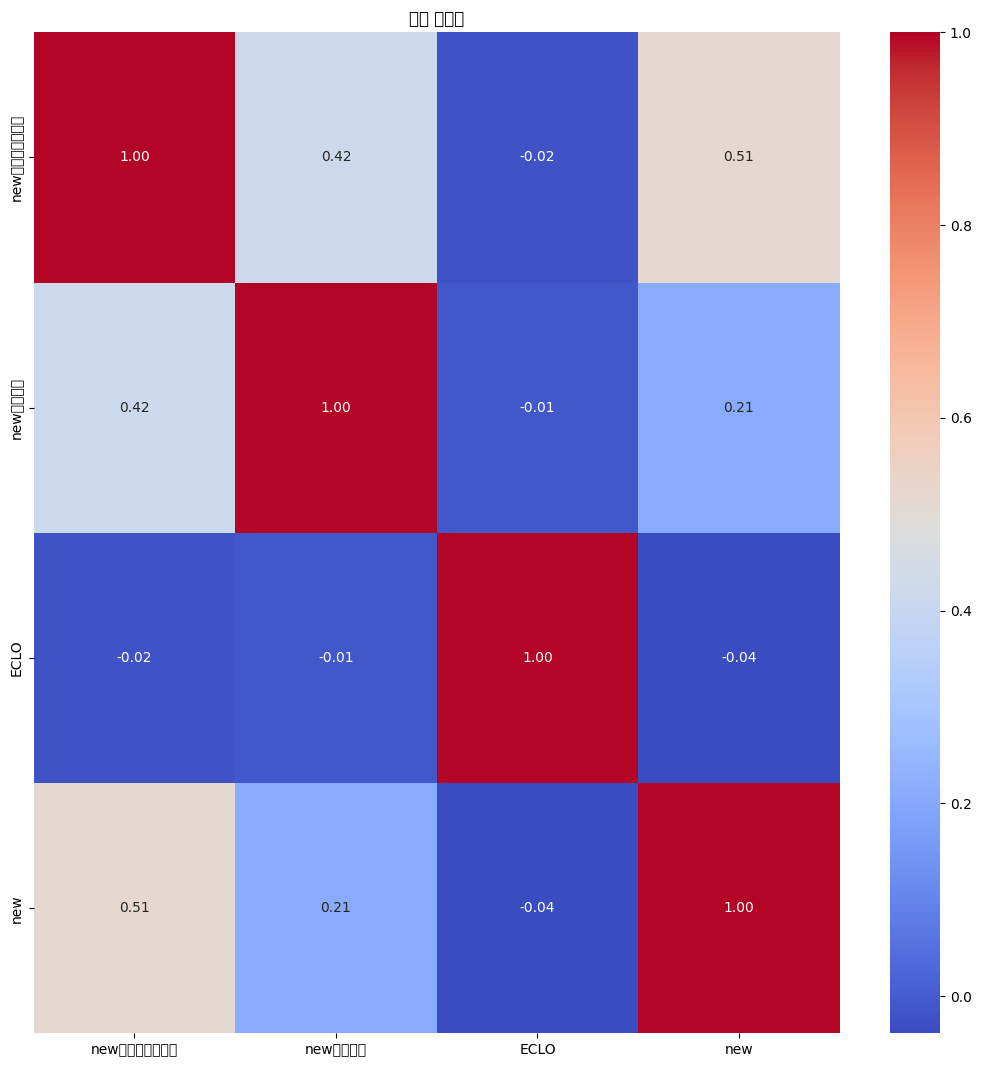

In [409]:
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트를 등록합니다.
fm.FontProperties(fname='NanumGothic.ttf')


# 상관관계표를 생성합니다.
corr = tr.corr()

# 상관관계표를 그립니다.
plt.figure(figsize=(13, 13))  # 그래프 크기 설정
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")  # 상관관계 히트맵 생성
plt.title('상관 히트맵')  # 그래프 제목 설정
plt.show()

In [87]:
train_df.describe()

,ECLO,연,월,일,시간,설치형태_건축물,설치형태_전용주,설치형태_한전주,설치개수,설치개수평균,시설종류_어린이집,시설종류_유치원,시설종류_초등학교,시설종류_특수학교,시설종류_학원,관할경찰서명_강북경찰서,관할경찰서명_남부경찰서,관할경찰서명_달성경찰서,관할경찰서명_대구광역시 중부경찰서,관할경찰서명_대구동부경찰서,관할경찰서명_북부경찰서,관할경찰서명_서부경찰서,관할경찰서명_수성경찰서,CCTV설치여부_N,CCTV설치여부_Y,CCTV설치한곳의수,CCTV설치대수,CCTV설치대수평균,급지구분_1,급지구분_2,급지구분_3,결제방법_교통카드,결제방법_무료,결제방법_신용카드,"결제방법_신용카드, 교통카드",결제방법_카드,결제방법_현금,결제방법_현금+신용카드,"결제방법_현금, 신용카드","결제방법_현금,카드",주차장구분_공영,주차장구분_민영,주차장유형_노상,주차장유형_노외,주차구획수,주차구획수평균,주차기본요금,추가단위요금,1일주차권요금,월정기권요금,도로노선방향_1,도로노선방향_2,도로노선방향_3,무인CCTV설치한곳의수,설치연도,제한속도
count,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000,30096.000000,30096.000000,30096.000000,30096.000000,30096.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.0,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,21183.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.000000,33066.00000,33066.000000,33066.000000,24540.000000,23141.000000,22398.000000,38033.000000,38033.000000,38033.000000,38033.000000,38033.000000,38033.000000
mean,4.726704,2019.939332,6.678507,15.817087,13.934863,148.281067,8.084762,369.095827,881.939427,1.006913,3.263372,5.789831,4.001936,0.456168,0.042865,1.258226,2.435160,3.763490,0.179106,0.0,0.901336,2.093282,2.923571,3.593400,9.960770,13.554171,19.430109,1.813463,2.549961,4.501210,3.164217,0.009043,0.038166,0.020958,0.005141,0.061786,2.714752,0.000544,0.022319,0.083772,9.477893,0.737495,6.088762,4.126626,454.17202,52.584840,253.650388,421.779472,4910.845315,55673.601283,5.411800,4.442353,3.978913,13.833066,2017.872704,38.508138
std,3.207206,0.818317,3.404229,8.792314,5.626818,393.983807,16.747296,860.091743,1206.169820,0.013900,2.820451,6.873894,3.242962,1.378221,0.202556,3.366381,7.217335,12.910862,1.121680,0.0,2.521439,5.434791,5.686418,11.998589,7.274513,12.301583,30.312800,2.281858,5.350670,7.754603,4.481865,0.094663,0.198119,0.143246,0.071519,0.283674,3.604362,0.023326,0.147721,0.277050,11.035736,2.053300,9.724237,4.731499,547.30896,41.082893,318.936268,432.264870,3249.895628,28324.407295,4.868346,4.096856,8.121049,13.831080,1.777575,15.435274
min,1.000000,2019.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000
25%,3.000000,2019.000000,4.000000,8.000000,10.000000,0.000000,0.000000,0.000000,237.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,124.00000,30.870000,0.000000,166.670000,3000.000000,40000.000000,2.000000,1.000000,0.000000,4.000000,2017.000000,26.670000
50%,3.000000,2020.000000,7.000000,16.000000,15.000000,0.000000,0.000000,0.000000,528.000000,1.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,8.000000,9.000000,4.000000,0.070000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,3.000000,277.00000,41.430000,142.860000,250.000000,4666.670000,57272.730000,4.000000,3.000000,0.000000,11.000000,2018.150000,42.730000
75%,6.000000,2021.000000,10.000000,23.000000,18.000000,36.000000,16.000000,346.000000,968.000000,1.010000,4.000000,7.000000,

In [149]:
for i in ['사망자수', '중상자수', '경상자수', '부상자수'] :
  display(train_df.groupby([i])['ECLO'].mean())

사망자수
0     4.667786
1    12.023973
2    27.875000
Name: ECLO, dtype: float64

중상자수
0     4.089428
1     6.103851
2    12.849515
3    18.448980
4    29.571429
5    29.500000
6    36.000000
Name: ECLO, dtype: float64

경상자수
0      4.332069
1      3.441878
2      6.673381
3      9.704861
4     12.930328
5     15.988417
6     19.727273
7     24.281250
8     25.428571
9     34.142857
10    35.000000
11    34.000000
12    56.000000
13    39.000000
14    47.000000
15    55.000000
18    74.000000
22    66.000000
Name: ECLO, dtype: float64

부상자수
0      4.927491
1      2.891251
2      4.921147
3      6.223881
4      7.771429
5      9.555556
6     19.333333
7      7.000000
10    19.000000
Name: ECLO, dtype: float64

In [150]:
for i in ['사망자수', '중상자수', '경상자수', '부상자수'] :
  display(train_df[i].value_counts())

0    39309
1      292
2        8
Name: 사망자수, dtype: int64

0    30136
1     8724
2      618
3       98
4       28
5        4
6        1
Name: 중상자수, dtype: int64

1     20913
0     10284
2      5560
3      1728
4       732
5       259
6        77
7        32
8         7
9         7
10        2
15        2
14        1
11        1
12        1
18        1
13        1
22        1
Name: 경상자수, dtype: int64

0     35168
1      4046
2       279
3        67
4        35
5         9
6         3
7         1
10        1
Name: 부상자수, dtype: int64

In [ ]:
# 'ECLO'
# '요일', '기상상태', '도로형태', '노면상태', '사고유형',
# '연', '월', '일', '시간',
# '도시', '구', '동',
# '도로형태1', '도로형태2',
# '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
# '설치개수', '설치개수평균',
# '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교','시설종류_학원'
# '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
# '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서',
# '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서',
# 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수','CCTV설치대수평균',
# '급지구분_1', '급지구분_2', '급지구분_3',
# '결제방법_교통카드', '결제방법_무료','결제방법_신용카드', '결제방법_신용카드, 교통카드',
# '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드','결제방법_현금, 신용카드', '결제방법_현금,카드',
# '주차장구분_공영', '주차장구분_민영', '주차장유형_노상','주차장유형_노외',
# '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
# '도로노선방향_1', '도로노선방향_2', '도로노선방향_3',
# '무인CCTV설치한곳의수', '설치연도', '제한속도'

In [139]:
train_df.fillna(0, inplace=True)

In [50]:
train_df[['설치형태_건축물', '설치형태_전용주', '설치형태_한전주','CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수','CCTV설치대수평균']].corr().round(2)

,설치형태_건축물,설치형태_전용주,설치형태_한전주,CCTV설치여부_N,CCTV설치여부_Y,CCTV설치한곳의수,CCTV설치대수,CCTV설치대수평균
설치형태_건축물,1.00,0.40,0.99,-0.07,0.55,0.30,0.84,0.39
설치형태_전용주,0.40,1.00,0.47,-0.09,0.01,-0.06,0.15,0.05
설치형태_한전주,0.99,0.47,1.00,-0.08,0.52,0.27,0.80,0.34
CCTV설치여부_N,-0.07,-0.09,-0.08,1.00,-0.05,0.76,-0.03,-0.09
CCTV설치여부_Y,0.55,0.01,0.52,-0.05,1.00,0.61,0.66,0.35
CCTV설치한곳의수,0.30,-0.06,0.27,0.76,0.61,1.00,0.40,0.16
CCTV설치대수,0.84,0.15,0.80,-0.03,0.66,0.40,1.00,0.68
CCTV설치대수평균,0.39,0.05,0.34,-0.09,0.35,0.16,0.68,1.00


In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_df[['급지구분_1', '급지구분_2', '급지구분_3']])
train_df = train_df.drop(['급지구분_1', '급지구분_2', '급지구분_3'], axis=1)
train_df['급지구분'] = pca_temp

train_df.shape

(39609, 65)

In [142]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_df[['결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드']])
train_df = train_df.drop(['결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드'], axis=1)
train_df['결제방법'] = pca_temp

train_df.shape

(39609, 61)

In [143]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_df[['도로노선방향_1', '도로노선방향_2', '도로노선방향_3']])
train_df = train_df.drop(['도로노선방향_1', '도로노선방향_2', '도로노선방향_3'], axis=1)
train_df['노선방향'] = pca_temp

train_df.shape

(39609, 59)

In [146]:
label_encoder = LabelEncoder()

# 데이터를 인코딩합니다.
train_df['요일'] = label_encoder.fit_transform(train_df['요일'])

In [147]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_df[['요일','시간']])
train_df = train_df.drop(['요일','시간'], axis=1)
train_df['요일시간'] = pca_temp

train_df.shape

(39609, 58)

In [153]:
display(train_df.groupby(['요일시간'])['ECLO'].mean().min())

3.9722222222222223

In [159]:
display(train_df.groupby(['동'])['ECLO'].mean().max())

10.333333333333334

In [151]:
train_df['요일시간'].describe()

count    3.960900e+04
mean     3.042441e-16
std      5.627112e+00
min     -9.096838e+00
25%     -4.086159e+00
50%     -1.042419e+00
75%      3.924339e+00
max      1.396766e+01
Name: 요일시간, dtype: float64

In [144]:
display(train_df.groupby(['결제방법'])['ECLO'].mean())
display(train_df.groupby(['노선방향'])['ECLO'].mean())

결제방법
-2.286598     4.438172
-2.276686     4.563008
-2.275657     4.510533
-2.266774     5.018124
-2.265799     3.333333
-2.265744     4.914855
-1.265888     4.666667
-1.265833     4.540416
-1.259905     4.990909
-0.266018     4.417647
-0.265922     4.613495
 0.733990     4.673038
 1.733901     4.564714
 1.739829     4.797386
 1.740452     4.571754
 2.733812     4.561966
 3.732694     4.555785
 3.733724     4.772727
 4.733635     4.532381
 5.733546     4.579812
 7.739920     4.832776
 8.733280     5.000000
 8.733280     4.587045
 8.739208     4.593750
 10.733103    4.492281
 13.732837    4.320388
Name: ECLO, dtype: float64

노선방향
-6.486350     5.041878
-6.245240     5.089757
-6.086064     4.940778
-6.004129     5.306977
-5.844954     4.776119
                ...   
 8.054787     4.540412
 10.059408    4.968000
 10.213793    4.293963
 14.158377    4.846599
 33.673196    4.492281
Name: ECLO, Length: 79, dtype: float64

In [96]:
display(train_df.groupby(['동'])['ECLO'].mean().tail(50))

동
유가읍      5.319838
유천동      4.668394
율암동      5.593750
율하동      4.777228
읍내동      4.793017
이곡동      4.540412
이천동      4.847926
이현동      4.927273
인교동      4.388889
입석동      5.041096
장관동      4.000000
장기동      4.773519
장동       4.672000
전동       4.666667
조야동      7.120000
종로1가     4.416667
종로2가     2.500000
죽전동      5.252708
중대동      6.024390
중동       4.470790
중리동      4.461905
지묘동      5.302083
지산동      4.563008
지저동      4.803371
진인동      7.823529
진천동      4.278956
칠성동1가    4.417647
칠성동2가    4.180147
침산동      4.673653
태전동      4.736170
태평로1가    3.821429
태평로2가    6.303030
태평로3가    5.125000
파동       4.683761
파호동      5.525641
팔달동      5.120968
평광동      6.000000
평리동      4.491525
포정동      3.961538
하빈면      5.267606
하서동      8.000000
학정동      4.786517
향촌동      3.400000
현풍읍      4.839335
호림동      5.833333
호산동      4.606218
화원읍      4.864865
화전동      3.333333
황금동      4.484694
효목동      4.840871
Name: ECLO, dtype: float64

In [91]:
display(train_df.groupby(['급지구분'])['ECLO'].mean())

급지구분
-4.909675     4.180147
-4.805844     4.320388
-4.702013     4.593750
-4.676056     5.000000
-4.676056     4.517986
-4.598183     3.511013
-4.572225     4.655527
-4.546267     4.725694
-4.520310     5.044118
-4.494352     4.345763
-4.468394     4.567568
-4.442437     4.616740
-4.416479     5.002392
-4.390521     4.996484
-4.390521     3.000000
-4.116272     6.000000
-4.038399     4.956296
-3.974081     4.492281
-3.686278     4.854333
-3.454927     4.556526
-3.334156     4.964722
-3.102805     4.576487
-2.982034     5.208183
-2.750683     4.529018
-2.629912     4.293963
-2.398561     3.000000
-2.398561     4.521705
-2.167211     4.537289
-1.925668     4.463198
-1.817358     4.906294
-1.815089     4.846599
-1.609697     4.619778
-1.573546     5.452555
-1.231617     4.782799
-0.527373     4.536934
-0.517180     4.461905
 0.539185     4.864865
 3.094232     4.500000
 3.822164     4.561538
 4.623491     4.448829
 5.790435     4.208920
 5.821014     5.600775
 8.476446     4.793017
 9.059

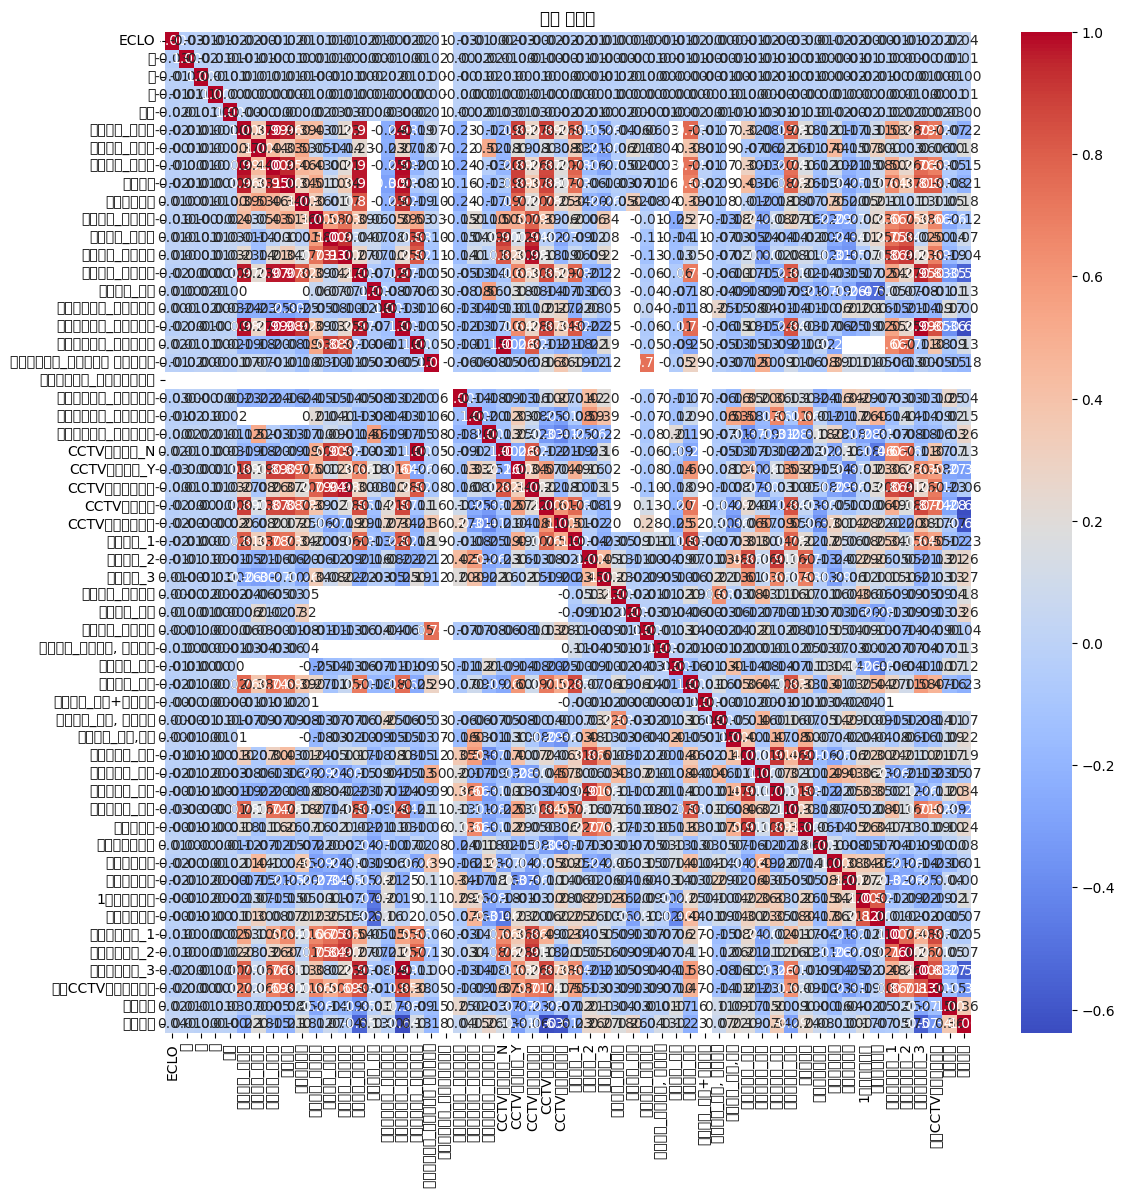

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트를 등록합니다.
fm.FontProperties(fname='NanumGothic.ttf')


# 상관관계표를 생성합니다.
corr = train_df.corr()

# 상관관계표를 그립니다.
plt.figure(figsize=(13, 13))  # 그래프 크기 설정
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")  # 상관관계 히트맵 생성
plt.title('상관 히트맵')  # 그래프 제목 설정
plt.show()

In [34]:
coor_ = train_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','ECLO',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']]

In [35]:
coor_.fillna(0, inplace=True)

In [36]:
coor_.columns = ['weekday', 'ground', 'acctype','road', 'build','line'
                  ,'eline','time','ea','mean','total','ECLO',
                  'dalsung','CCTV_N','fare','year', 'speed']

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(coor_[['build', 'eline','ea']])
coor_ = coor_.drop(['build', 'eline','ea'], axis=1)
coor_['build_eline_ea'] = pca_temp

coor_.shape

(39609, 15)

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(coor_[['dalsung', 'CCTV_N']])
coor_ = coor_.drop(['dalsung', 'CCTV_N'], axis=1)
coor_['dalsung_CCTV_N'] = pca_temp

coor_.shape

(39609, 14)

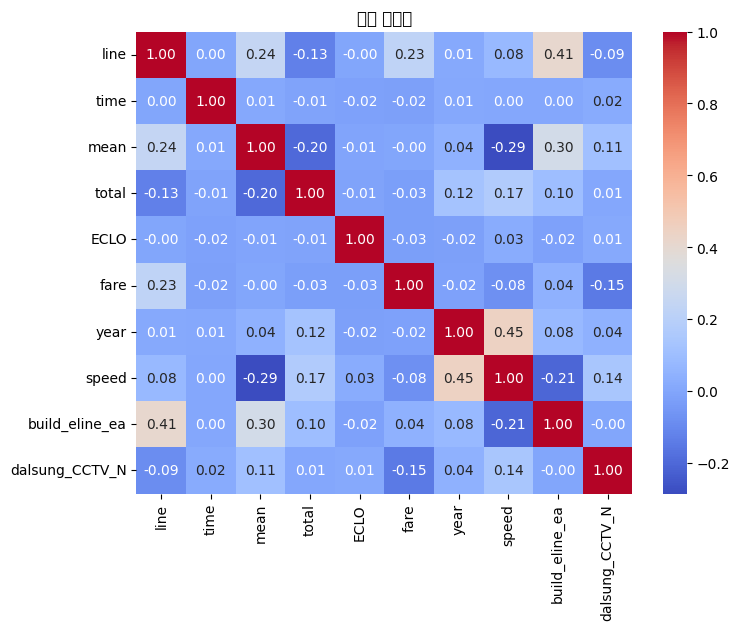

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트를 등록합니다.
fm.FontProperties(fname='NanumGothic.ttf')


# 상관관계표를 생성합니다.
corr = coor_.corr()

# 상관관계표를 그립니다.
plt.figure(figsize=(8, 6))  # 그래프 크기 설정
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")  # 상관관계 히트맵 생성
plt.title('상관 히트맵')  # 그래프 제목 설정
plt.show()

In [163]:
for i in coor_.columns.tolist() :
  display(coor_.groupby([i])['ECLO'].mean().min())
  display(coor_.groupby([i])['ECLO'].mean().max())
  print("-----------------------------------")

4.560687619378364

5.210257656781721

-----------------------------------


3.0

5.666666666666667

-----------------------------------


3.8176496414459242

4.944596507786692

-----------------------------------


3.7161016949152543

6.578125

-----------------------------------


3.6324786324786325

6.515151515151516

-----------------------------------


4.580698835274543

5.424157303370786

-----------------------------------


4.690759134444838

6.473684210526316

-----------------------------------


2.5

10.333333333333334

-----------------------------------


1.0

74.0

-----------------------------------


2.5

5.382978723404255

-----------------------------------


3.511013215859031

6.205882352941177

-----------------------------------


3.392857142857143

7.12

-----------------------------------


2.3333333333333335

10.333333333333334

-----------------------------------


4.613943028485757

5.60077519379845

-----------------------------------


In [112]:
train_df['ECLO'] = np.log(train_df['ECLO'])

<Axes: xlabel='ECLO', ylabel='Count'>

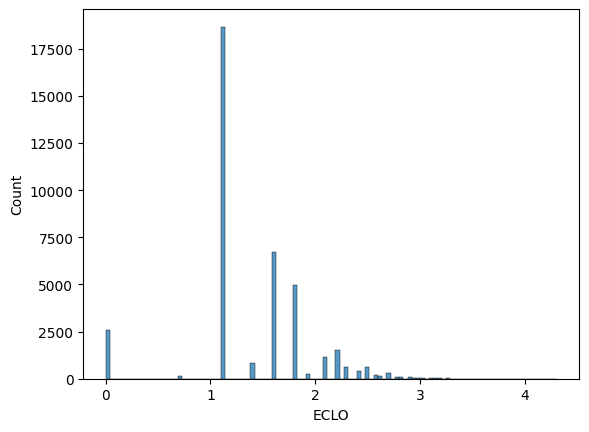

In [113]:
sns.histplot(train_df['ECLO'])

In [102]:
train_df_ = train_df.drop(columns=['ID'])

In [105]:
for i in train_df_.columns.tolist() :
  display(train_df_.groupby([i])['ECLO'].mean())

요일
금요일    4.600906
목요일    4.560688
수요일    4.627408
월요일    4.698049
일요일    5.210258
토요일    4.920811
화요일    4.627926
Name: ECLO, dtype: float64

기상상태
기타    4.946429
눈     4.625000
맑음    4.712888
비     4.895699
안개    5.500000
흐림    4.779150
Name: ECLO, dtype: float64

도로형태
교차로 - 교차로부근        4.863035
교차로 - 교차로안         5.006142
교차로 - 교차로횡단보도내     4.122795
기타 - 기타            4.065962
단일로 - 고가도로위        5.615942
단일로 - 교량           5.211207
단일로 - 기타           4.653990
단일로 - 지하차도(도로)내    4.576052
단일로 - 터널           6.578125
미분류 - 미분류          3.750000
주차장 - 주차장          3.716102
Name: ECLO, dtype: float64

노면상태
건조       4.712878
기타       4.086207
서리/결빙    4.160000
적설       3.000000
젖음/습기    4.906452
침수       5.666667
Name: ECLO, dtype: float64

사고유형
차대사람    3.817650
차대차     4.944597
차량단독    4.006054
Name: ECLO, dtype: float64

ECLO
1      1.0
2      2.0
3      3.0
4      4.0
5      5.0
6      6.0
7      7.0
8      8.0
9      9.0
10    10.0
11    11.0
12    12.0
13    13.0
14    14.0
15    15.0
16    16.0
17    17.0
18    18.0
19    19.0
20    20.0
21    21.0
22    22.0
23    23.0
24    24.0
25    25.0
26    26.0
27    27.0
28    28.0
30    30.0
31    31.0
32    32.0
33    33.0
34    34.0
35    35.0
36    36.0
37    37.0
39    39.0
40    40.0
45    45.0
47    47.0
52    52.0
56    56.0
57    57.0
65    65.0
66    66.0
74    74.0
Name: ECLO, dtype: float64

연
2019    4.842185
2020    4.718547
2021    4.597049
Name: ECLO, dtype: float64

월
1     4.661716
2     4.790057
3     4.880406
4     4.784682
5     4.644790
6     4.713531
7     4.700089
8     4.730909
9     4.734837
10    4.692308
11    4.855465
12    4.544451
Name: ECLO, dtype: float64

일
1     4.814509
2     4.822775
3     4.800155
4     4.792553
5     4.882123
6     4.730769
7     4.801237
8     4.527589
9     4.669207
10    4.792813
11    4.830065
12    4.889571
13    4.844548
14    4.706325
15    4.608150
16    4.701048
17    4.597656
18    4.733994
19    4.613033
20    4.626240
21    4.755271
22    4.762085
23    4.762738
24    4.582486
25    4.771272
26    4.697178
27    4.741132
28    4.637747
29    4.615442
30    4.691297
31    4.725034
Name: ECLO, dtype: float64

시간
0     5.071256
1     5.251121
2     5.407692
3     5.424157
4     5.128065
5     5.235546
6     4.664000
7     4.694147
8     4.669958
9     4.644957
10    4.580699
11    4.585317
12    4.660646
13    4.645132
14    4.605892
15    4.779697
16    4.664690
17    4.660895
18    4.608593
19    4.663746
20    4.675023
21    4.811321
22    4.947543
23    4.983577
Name: ECLO, dtype: float64

도시
대구광역시    4.726704
Name: ECLO, dtype: float64

구
남구     4.623681
달서구    4.618441
달성군    5.072280
동구     4.889534
북구     4.687669
서구     4.775680
수성구    4.727300
중구     4.541610
Name: ECLO, dtype: float64

동
가창면    5.321739
가천동    5.637931
각산동    5.137931
갈산동    4.909091
감삼동    4.738938
         ...   
호산동    4.606218
화원읍    4.864865
화전동    3.333333
황금동    4.484694
효목동    4.840871
Name: ECLO, Length: 196, dtype: float64

도로형태1
교차로    4.882281
기타     4.065962
단일로    4.671841
미분류    3.750000
주차장    3.716102
Name: ECLO, dtype: float64

도로형태2
고가도로위        5.615942
교량           5.211207
교차로부근        4.863035
교차로안         5.006142
교차로횡단보도내     4.122795
기타           4.599599
미분류          3.750000
주차장          3.716102
지하차도(도로)내    4.576052
터널           6.578125
Name: ECLO, dtype: float64

설치형태_건축물
0.0       4.705749
1.0       5.170320
2.0       4.661342
3.0       5.287500
4.0       4.996970
5.0       5.242424
7.0       4.711111
8.0       3.666667
9.0       4.611111
10.0      3.888889
11.0      3.896552
12.0      4.000000
13.0      5.150442
14.0      4.842444
15.0      4.835821
16.0      4.810811
17.0      5.125000
19.0      3.843750
20.0      4.967213
21.0      3.511013
23.0      3.951220
24.0      4.116279
25.0      5.382979
28.0      4.666667
32.0      4.320388
33.0      4.862500
34.0      4.641618
36.0      5.137255
47.0      4.463415
48.0      4.803371
53.0      5.051724
63.0      5.157143
65.0      5.294931
75.0      5.241935
78.0      4.692982
82.0      3.891892
83.0      4.597222
87.0      4.931624
104.0     4.881657
106.0     4.683761
163.0     4.470790
177.0     4.282443
192.0     4.702703
199.0     4.797386
251.0     4.655527
298.0     4.840871
394.0     4.968000
540.0     4.549091
592.0     4.593750
1647.0    4.492281
Name: ECLO, dtype: float64

설치형태_전용주
0.0      4.697177
1.0      4.681261
2.0      4.917127
3.0      5.512195
4.0      4.839721
5.0      5.225989
6.0      3.632479
7.0      5.150442
8.0      5.051724
9.0      5.137931
10.0     4.463415
11.0     5.216981
13.0     4.702703
15.0     6.515152
16.0     4.658588
17.0     5.041096
18.0     6.205882
20.0     4.545750
21.0     4.840871
22.0     4.968000
26.0     4.797386
28.0     4.926655
30.0     4.282443
31.0     4.842715
38.0     4.655527
57.0     4.549091
173.0    4.683761
Name: ECLO, dtype: float64

설치형태_한전주
0.0       4.692650
1.0       5.666667
2.0       4.625000
3.0       3.888889
4.0       3.333333
            ...   
787.0     4.692982
795.0     4.840871
974.0     4.968000
1396.0    4.549091
3583.0    4.492281
Name: ECLO, Length: 80, dtype: float64

설치개수
1.0       6.500000
2.0       3.875000
4.0       5.833333
5.0       5.142857
7.0       5.550000
            ...   
1365.0    4.448829
1424.0    4.968000
1474.0    4.593750
2057.0    4.549091
5377.0    4.492281
Name: ECLO, Length: 142, dtype: float64

설치개수평균
1.00    4.690759
1.01    4.956887
1.02    4.731692
1.03    4.693029
1.04    4.821016
1.05    4.798254
1.07    6.473684
1.17    6.117647
Name: ECLO, dtype: float64

시설종류_어린이집
0.0     4.821821
1.0     4.777681
2.0     4.653449
3.0     4.654526
4.0     4.708238
5.0     4.593750
6.0     5.600775
7.0     4.492281
8.0     4.665474
12.0    4.864865
Name: ECLO, dtype: float64

시설종류_유치원
0.0     4.816703
1.0     4.775184
2.0     4.743555
3.0     4.601434
4.0     4.684003
5.0     4.703163
6.0     4.993827
7.0     4.492281
8.0     4.980274
9.0     4.555785
11.0    4.619778
16.0    4.864865
36.0    4.859848
Name: ECLO, dtype: float64

시설종류_초등학교
0.0     4.702500
1.0     4.711446
2.0     4.826325
3.0     4.642019
4.0     4.826115
5.0     4.637896
6.0     4.711111
7.0     4.492281
8.0     5.600775
10.0    4.864865
16.0    4.859848
Name: ECLO, dtype: float64

시설종류_특수학교
0.0    4.747624
1.0    4.398693
5.0    4.492281
Name: ECLO, dtype: float64

시설종류_학원
0.0    4.707275
1.0    4.803965
Name: ECLO, dtype: float64

관할경찰서명_강북경찰서
0.0     4.696061
1.0     5.476821
3.0     5.593023
4.0     5.000000
5.0     5.042435
6.0     4.816949
7.0     4.607955
10.0    4.326648
13.0    4.756781
Name: ECLO, dtype: float64

관할경찰서명_남부경찰서
0.0     4.723475
6.0     4.702703
8.0     4.968000
26.0    4.492281
Name: ECLO, dtype: float64

관할경찰서명_달성경찰서
0.0     4.668458
6.0     5.463415
8.0     5.301075
12.0    5.319838
22.0    5.600775
38.0    4.864865
60.0    4.859848
Name: ECLO, dtype: float64

관할경찰서명_대구광역시 중부경찰서
0.0    4.715997
1.0    4.653110
2.0    4.588710
9.0    4.593750
Name: ECLO, dtype: float64

관할경찰서명_대구동부경찰서
0.0    4.71142
Name: ECLO, dtype: float64

관할경찰서명_북부경찰서
0.0     4.748117
1.0     4.206107
2.0     4.477778
4.0     4.180147
5.0     4.561538
7.0     4.673653
8.0     4.521047
11.0    4.208920
Name: ECLO, dtype: float64

관할경찰서명_서부경찰서
0.0     4.711742
2.0     5.106061
5.0     4.461905
9.0     5.018124
18.0    4.491525
19.0    4.555785
Name: ECLO, dtype: float64

관할경찰서명_수성경찰서
0.0     4.717683
1.0     4.932271
2.0     4.623529
3.0     4.750000
4.0     4.655693
5.0     4.737427
7.0     4.689034
8.0     4.423611
10.0    4.563008
18.0    4.803965
19.0    4.619778
Name: ECLO, dtype: float64

CCTV설치여부_N
0.0     4.667918
1.0     4.805695
2.0     4.613943
4.0     5.463415
8.0     5.301075
12.0    5.319838
20.0    5.600775
30.0    4.864865
58.0    4.859848
Name: ECLO, dtype: float64

CCTV설치여부_Y
0.0     5.311778
1.0     4.796004
2.0     4.982641
3.0     5.047619
4.0     4.481752
5.0     4.794426
6.0     4.645251
7.0     4.659657
8.0     4.728098
9.0     4.732779
10.0    4.464923
13.0    4.756781
16.0    4.803965
18.0    4.491525
19.0    4.590845
26.0    4.492281
Name: ECLO, dtype: float64

CCTV설치한곳의수
1.0     4.796004
2.0     4.777293
3.0     5.260563
4.0     4.549001
5.0     4.758704
6.0     4.948758
7.0     4.659657
8.0     4.744820
9.0     4.910175
10.0    4.464923
11.0    4.208920
12.0    5.319838
13.0    4.756781
18.0    4.649749
19.0    4.590845
22.0    5.600775
26.0    4.492281
38.0    4.864865
60.0    4.859848
Name: ECLO, dtype: float64

CCTV설치대수
0.0      4.727481
1.0      4.851852
2.0      4.666667
4.0      5.050821
5.0      7.120000
6.0      4.850467
7.0      5.593023
8.0      4.500000
9.0      4.493113
10.0     5.000000
11.0     5.157143
12.0     4.260000
13.0     4.282443
14.0     4.575163
16.0     5.147541
17.0     5.077640
18.0     4.876488
19.0     4.786517
20.0     4.180147
22.0     4.859259
23.0     4.673653
32.0     4.208920
34.0     4.706782
36.0     4.326648
49.0     4.793017
50.0     4.736170
61.0     4.593750
106.0    4.492281
Name: ECLO, dtype: float64

CCTV설치대수평균
0.00     4.727481
0.07     4.859848
0.18     5.600775
0.47     4.864865
0.67     5.463415
1.00     4.851852
1.80     4.561538
2.00     4.592920
2.33     4.918919
2.50     5.000000
2.67     5.147541
2.71     4.786517
2.91     4.208920
3.00     4.477778
3.29     4.673653
3.40     5.077640
3.60     4.326648
3.67     4.702703
3.77     4.793017
3.85     4.736170
4.00     4.153846
4.08     4.492281
4.25     4.706782
4.40     4.990909
5.00     4.427609
6.00     5.120968
6.50     4.282443
6.78     4.593750
8.00     4.500000
9.00     4.645455
11.00    5.157143
12.00    4.260000
Name: ECLO, dtype: float64

급지구분_1
0.0     4.704814
1.0     4.720302
2.0     4.616740
3.0     4.775578
4.0     4.345763
5.0     5.044118
6.0     4.594745
7.0     4.655527
8.0     4.419913
9.0     4.906294
11.0    4.519139
12.0    4.593750
16.0    4.320388
20.0    4.450272
Name: ECLO, dtype: float64

급지구분_2
0.0     4.762997
1.0     4.530945
2.0     4.647575
3.0     4.675189
7.0     4.448829
8.0     4.500000
9.0     4.342566
12.0    4.491525
13.0    4.793017
14.0    4.796757
15.0    4.722854
18.0    5.018124
29.0    4.521047
30.0    4.555785
Name: ECLO, dtype: float64

급지구분_3
0.0     4.616320
1.0     4.752319
2.0     4.797427
3.0     4.688370
4.0     5.208183
5.0     4.270873
7.0     4.455910
8.0     5.452555
9.0     4.491525
11.0    4.461905
13.0    4.539253
14.0    4.853630
29.0    5.600775
Name: ECLO, dtype: float64

결제방법_교통카드
0.0    4.671926
1.0    4.832776
Name: ECLO, dtype: float64

결제방법_무료
0.0    4.666300
1.0    4.837861
2.0    5.428571
Name: ECLO, dtype: float64

결제방법_신용카드
0.0    4.671424
1.0    4.764791
Name: ECLO, dtype: float64

결제방법_신용카드, 교통카드
0.0    4.674702
1.0    4.417647
Name: ECLO, dtype: float64

결제방법_카드
0.0    4.682083
1.0    4.530408
2.0    4.438172
Name: ECLO, dtype: float64

결제방법_현금
0.0     4.823104
1.0     4.559717
2.0     4.604903
3.0     4.673038
4.0     4.583495
5.0     4.561966
6.0     4.595960
7.0     4.532381
8.0     4.579812
10.0    4.832776
11.0    4.591549
13.0    4.492281
16.0    4.320388
Name: ECLO, dtype: float64

결제방법_현금+신용카드
0.0    4.673505
1.0    4.444444
Name: ECLO, dtype: float64

결제방법_현금, 신용카드
0.0    4.673286
1.0    4.677507
Name: ECLO, dtype: float64

결제방법_현금,카드
0.0    4.671145
1.0    4.697834
Name: ECLO, dtype: float64

주차장구분_공영
0.0     4.369085
1.0     4.733283
2.0     4.783692
3.0     4.701413
4.0     4.766115
5.0     4.359535
6.0     4.538809
7.0     4.549469
8.0     5.452555
10.0    4.438462
11.0    4.461905
12.0    4.968000
13.0    4.545319
14.0    4.520647
15.0    4.745148
18.0    5.018124
19.0    4.832776
21.0    4.492027
22.0    4.673653
29.0    5.600775
40.0    4.521047
49.0    4.555785
Name: ECLO, dtype: float64

주차장구분_민영
0.0     4.690575
1.0     4.852761
2.0     4.604440
3.0     4.721612
4.0     4.338710
5.0     4.679818
6.0     3.333333
7.0     4.403716
8.0     3.511013
10.0    4.860577
11.0    4.282443
14.0    4.320388
Name: ECLO, dtype: float64

주차장유형_노상
0.0     4.683422
1.0     4.637264
2.0     4.807018
3.0     4.675055
4.0     4.911321
5.0     4.606511
6.0     4.573529
7.0     4.500000
8.0     4.879479
9.0     4.557538
10.0    4.302905
11.0    4.492140
12.0    4.864865
14.0    4.736170
15.0    4.561538
17.0    4.772385
21.0    4.673653
28.0    5.600775
29.0    4.521047
44.0    4.555785
Name: ECLO, dtype: float64

주차장유형_노외
0.0     4.860173
1.0     4.764259
2.0     4.817660
3.0     4.581587
4.0     4.685772
5.0     4.428150
6.0     5.012048
7.0     4.571754
8.0     3.511013
9.0     4.841270
10.0    4.406170
11.0    4.282443
12.0    4.832776
13.0    4.521047
14.0    4.320388
20.0    4.492281
Name: ECLO, dtype: float64

주차구획수
10.0      5.400000
11.0      3.333333
17.0      5.120968
20.0      3.727273
22.0      3.300000
            ...   
1035.0    5.018124
1423.0    4.832776
1475.0    4.521047
2574.0    5.600775
2725.0    4.555785
Name: ECLO, Length: 111, dtype: float64

주차구획수평균
10.00     5.400000
10.67     4.803965
11.00     3.333333
14.33     4.702703
15.00     4.000000
            ...   
224.00    4.750000
225.00    5.319838
229.33    5.833333
300.00    5.379310
643.00    5.390244
Name: ECLO, Length: 113, dtype: float64

주차기본요금
0.00       4.861237
21.43      4.448829
33.33      5.018124
50.00      4.278956
71.43      4.208920
80.00      4.406456
88.10      4.521047
97.96      4.555785
117.65     4.561538
120.00     4.793017
142.86     4.491525
150.00     4.797784
164.00     4.673653
166.67     4.518987
200.00     4.838095
204.76     4.492281
225.00     4.464548
271.43     4.326648
275.00     4.500000
283.33     4.968000
300.00     4.648921
333.33     4.466667
400.00     4.762295
465.52     4.832776
500.00     4.180147
545.45     4.417647
600.00     4.618824
700.00     4.603003
750.00     4.588235
833.33     3.821429
900.00     5.379310
916.67     4.593750
933.33     5.077640
966.67     5.382979
1000.00    4.658665
1125.00    2.500000
1136.36    4.282443
1137.50    4.320388
1250.00    3.803125
1333.33    3.789474
1500.00    5.318182
Name: ECLO, dtype: float64

추가단위요금
0.00       4.880464
75.00      4.880000
100.00     4.633670
150.00     4.566051
166.67     4.451985
200.00     4.635392
207.69     4.492281
225.00     4.968000
250.00     4.504290
300.00     4.731755
333.33     4.797386
350.00     4.619778
357.14     4.555785
400.00     3.392857
462.50     4.673653
500.00     4.634047
594.44     4.832776
625.00     4.653465
666.67     4.484694
700.00     6.303030
750.00     4.459459
800.00     5.382979
875.00     4.739130
900.00     4.931624
916.67     4.180147
961.54     4.320388
1000.00    4.640625
1100.00    4.504013
1150.00    4.793017
1166.67    3.493506
1250.00    4.666667
1500.00    4.604752
2000.00    4.356627
Name: ECLO, dtype: float64

1일주차권요금
0.00        4.719374
1000.00     4.571754
1500.00     4.880000
2000.00     4.616939
3000.00     4.751943
3333.33     4.438172
3500.00     4.293963
3545.45     4.492281
3666.67     4.464548
4000.00     4.909884
4250.00     4.968000
4666.67     4.521047
5000.00     4.442516
5250.00     4.180147
6000.00     4.707666
6857.14     4.555785
7000.00     4.589498
8000.00     4.942857
8333.33     4.605469
8500.00     5.382979
10000.00    4.592574
15000.00    3.789474
15083.33    4.832776
50000.00    3.961538
Name: ECLO, dtype: float64

월정기권요금
0.00         4.719374
20000.00     4.598416
30000.00     4.777228
40000.00     4.715092
50000.00     4.349700
55000.00     4.326648
57272.73     4.492281
60000.00     4.569351
63750.00     4.968000
65000.00     4.561538
70000.00     4.518784
80000.00     4.703590
83333.33     4.797386
85000.00     4.663914
86000.00     4.491525
94285.71     4.555785
100000.00    4.688776
120000.00    3.789474
Name: ECLO, dtype: float64

도로노선방향_1
0.0     4.837034
1.0     4.743558
2.0     4.760286
3.0     4.784148
4.0     4.733953
5.0     4.759165
6.0     4.562368
7.0     4.681799
8.0     4.698266
9.0     4.726679
10.0    5.321739
11.0    4.293963
14.0    5.600775
15.0    4.864865
17.0    4.492281
23.0    4.859848
Name: ECLO, dtype: float64

도로노선방향_2
0.0     4.861193
1.0     4.765080
2.0     4.757958
3.0     4.606420
4.0     4.873148
5.0     4.631258
6.0     4.722901
7.0     4.549644
8.0     4.846599
9.0     4.839416
10.0    4.492027
18.0    4.864865
21.0    4.859848
Name: ECLO, dtype: float64

도로노선방향_3
0.0     4.781369
1.0     4.955595
2.0     4.732054
3.0     4.464548
4.0     4.593003
5.0     4.546457
6.0     4.381065
8.0     4.738938
10.0    4.448829
12.0    4.293963
13.0    4.594075
15.0    4.968000
18.0    4.846599
35.0    4.492281
Name: ECLO, dtype: float64

무인CCTV설치한곳의수
1.0     4.975054
2.0     4.877500
3.0     4.830311
4.0     4.723175
5.0     5.169620
6.0     4.726246
7.0     4.776204
8.0     4.855156
9.0     4.614180
10.0    4.446717
11.0    4.610004
12.0    4.571524
13.0    4.899287
14.0    4.555785
15.0    4.862170
16.0    4.673653
17.0    4.636453
18.0    5.600775
22.0    4.648867
23.0    4.540412
24.0    4.968000
30.0    4.293963
33.0    4.854735
44.0    4.859848
62.0    4.492281
Name: ECLO, dtype: float64

설치연도
2006.00    3.821429
2007.50    3.511013
2008.00    3.900000
2010.00    5.110092
2011.00    4.845494
             ...   
2020.38    4.702703
2020.50    4.597222
2020.67    5.288889
2020.80    5.593023
2021.00    5.501873
Name: ECLO, Length: 78, dtype: float64

제한속도
0.00      4.491489
8.00      4.282443
12.00     5.833333
13.33     3.392857
14.58     4.968000
            ...   
71.00     4.683761
76.67     5.150442
80.00     7.120000
92.00     6.205882
100.00    5.506667
Name: ECLO, Length: 68, dtype: float64

# 상관관계표

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.columns = ['id', 'day of the week',
                 'weather condition', 'road type',
                 'road surface condition', 'accident type',
                 'eclo', 'year', 'month', 'day', 'time',
                 'city', 'district', 'dong', 'road type 1', 'road type 2',
                 'number of installations', 'year of installation_x', 'number of cctv installations',
                 'cnt', 'number of parking lots', 'basic parking time', 'basic parking fee',
                 'additional unit time', 'additional unit fee', '1-day parking ticket fee application time',
                 'daily parking ticket fee', 'monthly parking ticket fee',
                 'payment classification_1', 'payment classification_2', 'payment classification_3',
                 'road route direction', 'speed control classification',
                 'speed limit', 'speed control section location classification', 'speed control section length',
                 'protection area classification', 'year of installation_y']

In [ ]:
categorical_features = list(train.dtypes[train.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])

['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

In [62]:
# 상관 계수 행렬 생성
correlation_matrix = train.corr()

# 상관 히트맵 그리기
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Hit map')
plt.show()

NameError: ignored

# EDA


In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.head()

,ID,요일,기상상태,도로형태,노면상태,사고유형,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,설치연도_x,CCTV설치대수,cnt,주차구획수,주차기본시간,주차기본요금,추가단위시간,추가단위요금,1일주차권요금적용시간,1일주차권요금,월정기권요금,급지구분_1,급지구분_2,급지구분_3,도로노선방향,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도_y
0,ACCIDENT_00000,화요일,맑음,단일로 - 기타,건조,차대사람,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,391.0,527861.0,13.0,2.0,500.0,360.0,12500.0,150.0,5500.0,0.0,0.0,0.0,11.0,0.0,0.0,14.0,18.0,40.0,0.0,0.0,4.0,10065.0
1,ACCIDENT_00001,화요일,흐림,단일로 - 기타,건조,차대사람,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타,932.0,1863897.0,NaN,NaN,114.0,2940.0,600.0,20.0,400.0,0.0,0.0,160000.0,0.0,1.0,3.0,29.0,39.0,210.0,0.0,0.0,301.0,24184.0
2,ACCIDENT_00002,화요일,맑음,단일로 - 기타,건조,차대사람,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타,473.0,632815.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,6.0,220.0,0.0,0.0,396.0,8073.0
3,ACCIDENT_00003,화요일,맑음,단일로 - 기타,건조,차대차,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타,534.0,0.0,32.0,11.0,374.0,30.0,1000.0,60.0,2000.0,0.0,10000.0,0.0,0.0,9.0,5.0,13.0,18.0,380.0,0.0,0.0,602.0,20183.0
4,ACCIDENT_00004,화요일,맑음,단일로 - 기타,건조,차대차,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타,2057.0,0.0,NaN,NaN,63.0,30.0,600.0,10.0,300.0,3.5,6000.0,80000.0,0.0,1.0,0.0,15.0,22.0,480.0,0.0,0.0,509.0,24219.0


In [ ]:
train['도로형태'].unique()

array(['단일로 - 기타', '교차로 - 교차로안', '기타 - 기타', '단일로 - 터널', '단일로 - 지하차도(도로)내',
       '단일로 - 교량', '교차로 - 교차로횡단보도내', '주차장 - 주차장', '교차로 - 교차로부근',
       '단일로 - 고가도로위', '미분류 - 미분류'], dtype=object)

In [ ]:
import geopandas as gpd

# GPKG 파일을 읽어들임
data = gpd.read_file('횡단보도_100.gpkg')

In [ ]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        89316 non-null  int64   
 1   count     8362 non-null   float64 
 2   geometry  89316 non-null  geometry
dtypes: float64(1), geometry(1), int64(1)
memory usage: 2.0 MB


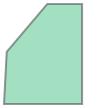

In [ ]:
data['geometry'].iloc[1]